<a href="https://colab.research.google.com/github/yejinhwang6101/electricity-power/blob/main/xgboost_lstmae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sys
import tqdm as tq
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached numpy-1.24.3-cp38-cp38-win_amd64.whl (14.9 MB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.13.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorf

  You can safely remove it manually.


In [ ]:
pip install --upgrade tensorflow

  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata (2.6 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#####  - time series를 일반 regression 문제로 변환하기 위해 시간 관련 변수 추가(월 / 주 / 요일)
#####  - 전력소비량의 요일별 시간대별 평균 / 시간대별 표준편차 변수 추가
###### - 요일별 시간대별 표준편차 / 평균 등 여러 통계량 생성 후 테스트, 최종적으로 성능 향상에 도움이 된 위 변수만 추가
#####  - 공휴일 변수 추가
#####  - 시간(hour)는 cyclical encoding하여 변수 추가(sin time & cos time) 후 삭제
#####  - CDH(Cooling Degree Hour) & THI(불쾌지수) 변수 추가

In [ ]:
df = pd.read_csv("power.csv", low_memory=False)

# 데이터 정제 과정
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 숫자로 변환할 수 없는 값은 NaN으로 설정

print("="*50)
print("First Five Rows ","\n")
print(df.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

First Five Rows  

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0   

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         

In [ ]:
# Extract all Data Like Year MOnth Day Time etc
dataset = df
# 날짜 및 시간 관련 변수 생성
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# 요일별 및 시간대별 통계 계산
grouped = df.groupby(['Week', 'Hour'])
mean_day = grouped['Global_active_power'].mean().reset_index()
std_day = grouped['Global_active_power'].std().reset_index()
skew_day = grouped['Global_active_power'].apply(lambda x: 3 * (x.mean() - x.median()) / x.std()).reset_index()

# 데이터 프레임에 추가
df = df.merge(mean_day, on=['Week', 'Hour'], suffixes=('', '_mean'))
df = df.merge(std_day, on=['Week', 'Hour'], suffixes=('', '_std'))
df = df.merge(skew_day, on=['Week', 'Hour'], suffixes=('', '_skew'))

dataset.head(1)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Hour,Week,Month,Year
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17,5,12,2006


In [ ]:
# 'Global_active_power' 컬럼에서 이상치 식별
Q1 = df['Global_active_power'].quantile(0.25)
Q3 = df['Global_active_power'].quantile(0.75)
IQR = Q3 - Q1

# 이상치의 범위를 정의 (일반적으로 Q1 - 1.5*IQR 이하 또는 Q3 + 1.5*IQR 이상)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치를 포함하는 행을 필터링
outliers = df[(df['Global_active_power'] < lower_bound) | (df['Global_active_power'] > upper_bound)]

# 이상치 제거
df_cleaned = df[~((df['Global_active_power'] < lower_bound) | (df['Global_active_power'] > upper_bound))]

print(f"Original Data Size: {df.shape[0]}")
print(f"Cleaned Data Size: {df_cleaned.shape[0]}")
print(f"Number of Outliers Removed: {df.shape[0] - df_cleaned.shape[0]}")

Original Data Size: 2075259
Cleaned Data Size: 1980352
Number of Outliers Removed: 94907


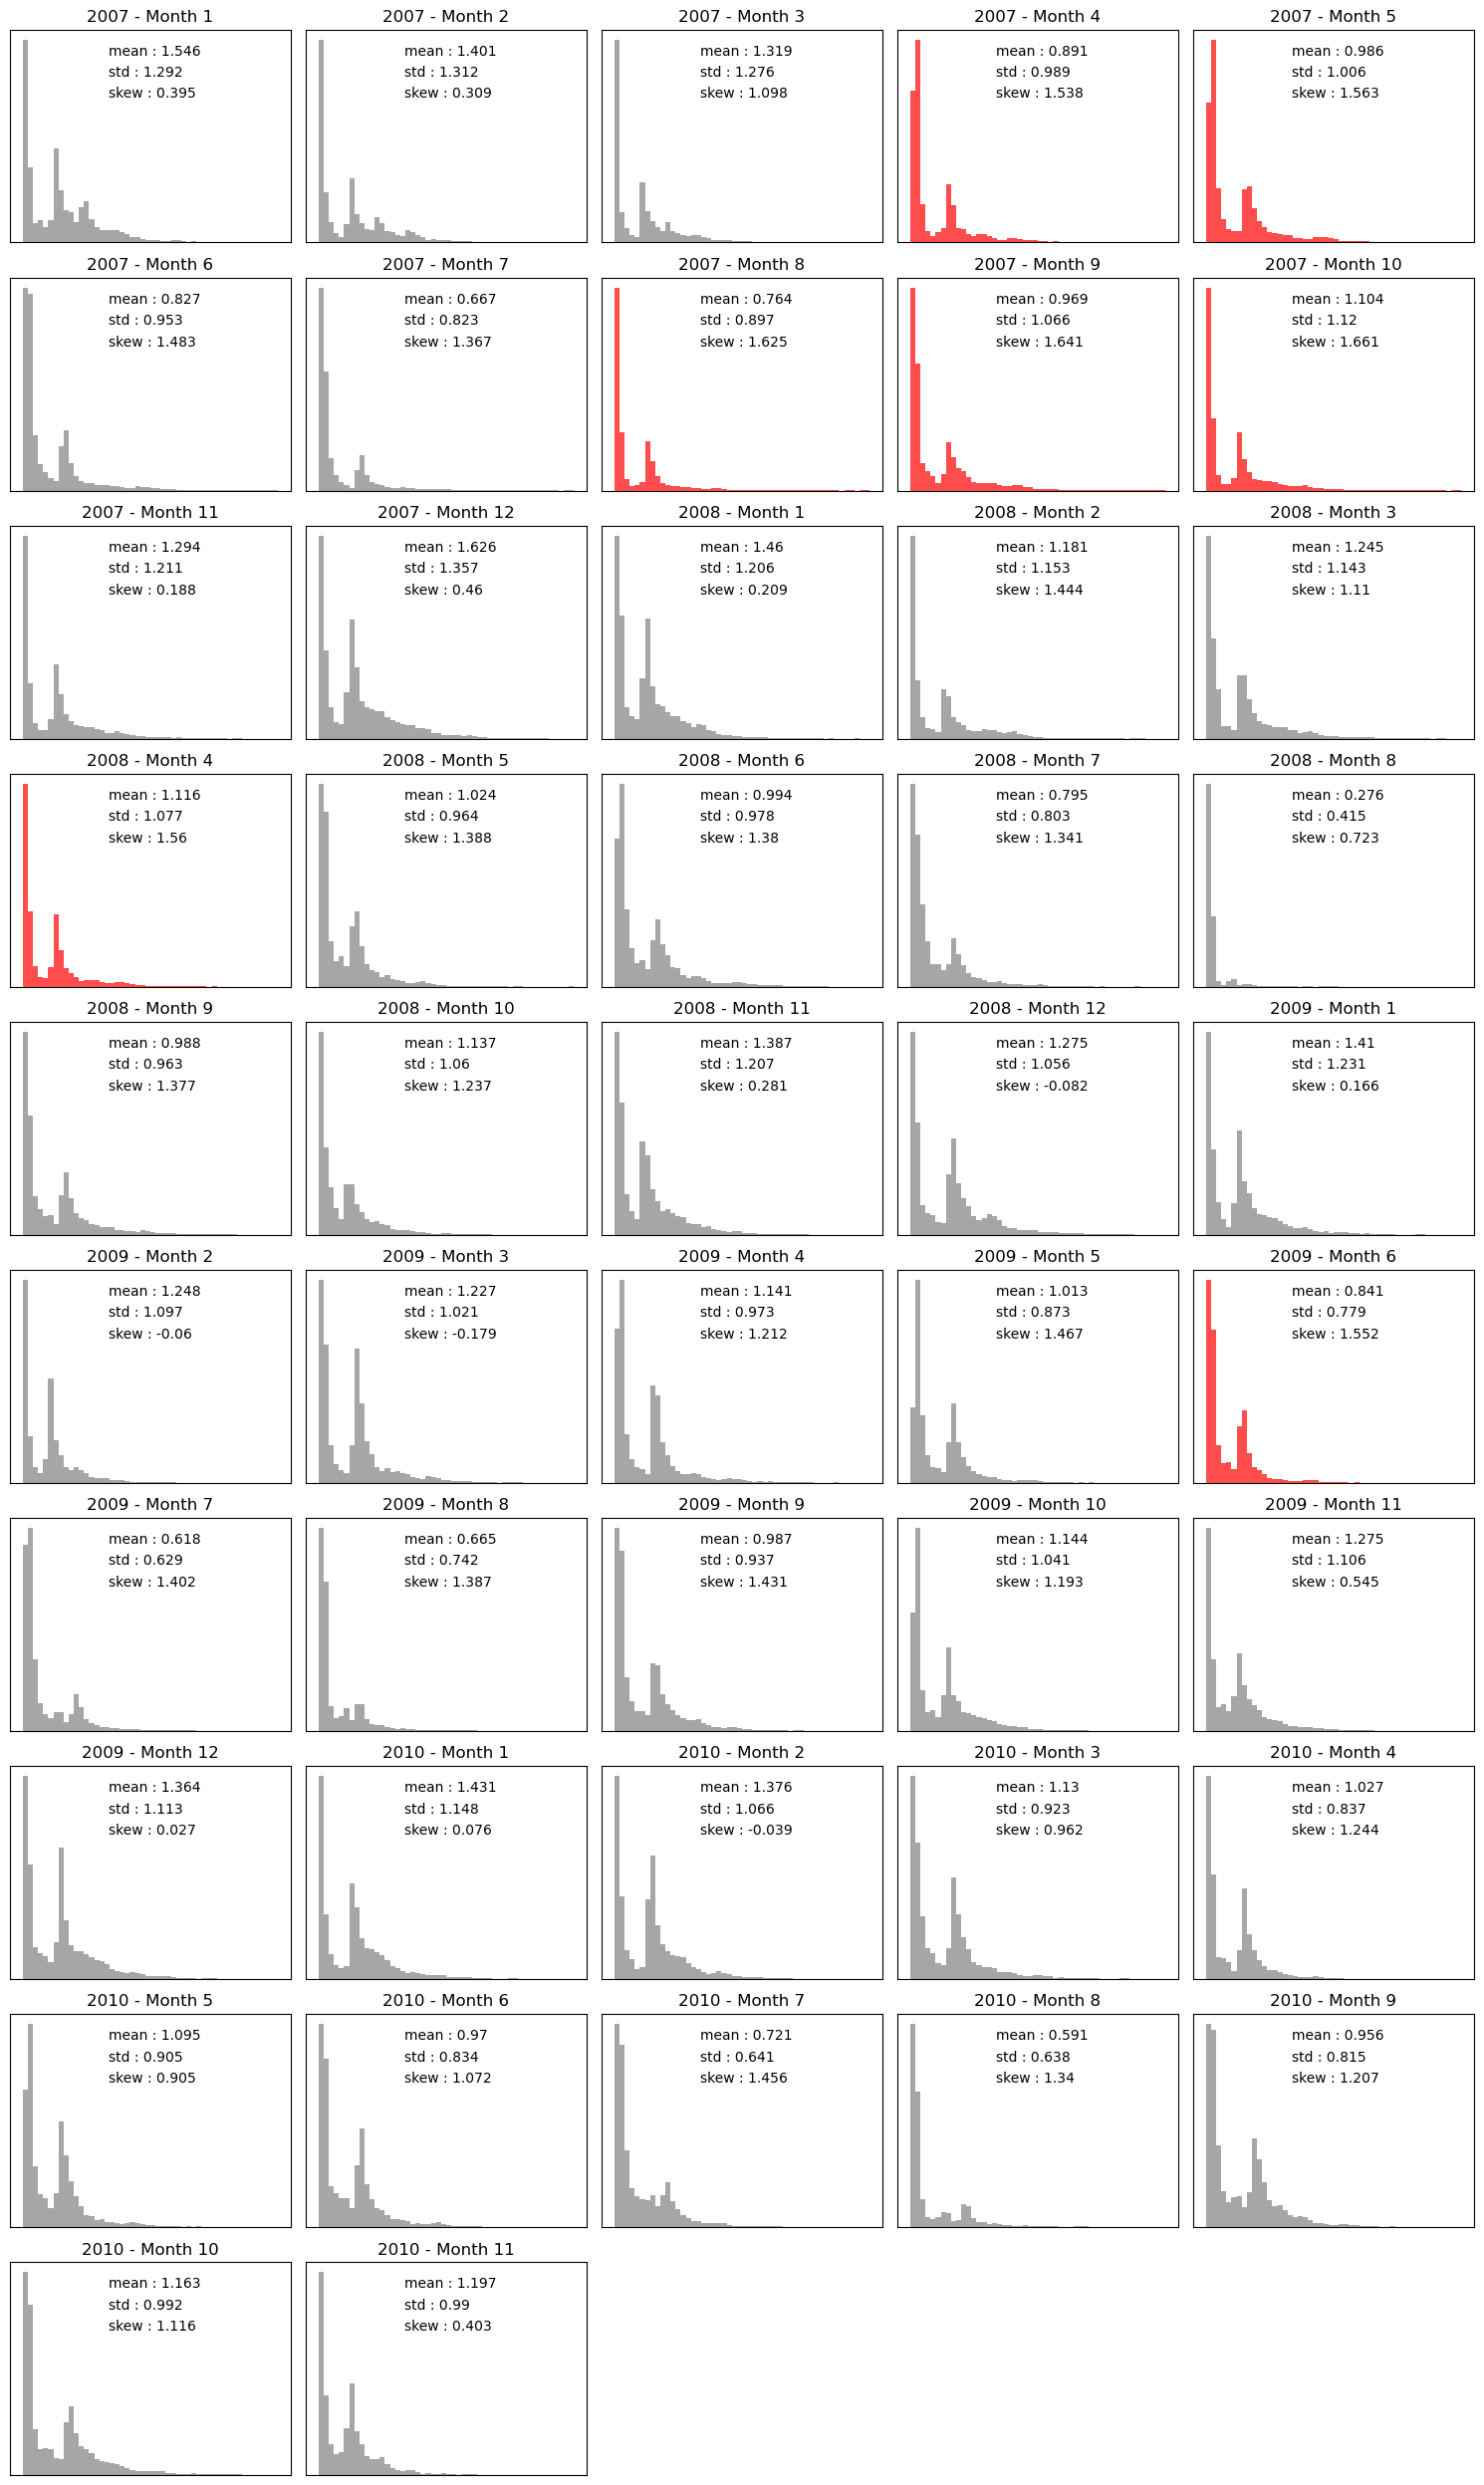

In [ ]:
# 그래프 설정
fig = plt.figure(figsize=(15, 40))

# 2007년부터 2010년까지 각 연도의 월별 서브플롯 생성
for year in range(2007, 2011):
    for month in range(1, 13):
        if year == 2010 and month > 11:
            break
        ax = plt.subplot(16, 5, (year - 2007) * 12 + month)
        monthly_data = df[(df['Year'] == year) & (df['Month'] == month)]['Global_active_power'].dropna()
        mean = monthly_data.mean()
        std = monthly_data.std()

        # std가 NaN인 경우 0으로 처리
        mean = round(mean, 3) if not np.isnan(mean) else 0
        std = round(std, 3) if not np.isnan(std) else 0
        skew = 0 if std == 0 else round((3 * (mean - np.median(monthly_data)) / std), 3)

        # 왜도에 따른 히스토그램 색상 설정
        color = 'gray'
        if skew >= 1.5:
            color = 'red'
        elif skew <= -1.5:
            color = 'blue'

        # 히스토그램 그리기
        plt.hist(monthly_data, alpha=0.7, bins=50, color=color)
        plt.title(f'{year} - Month {month}')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')
        plt.text(0.35, 0.9, f'mean : {mean}', ha='left', va='center', transform=ax.transAxes)
        plt.text(0.35, 0.8, f'std : {std}', ha='left', va='center', transform=ax.transAxes)
        plt.text(0.35, 0.7, f'skew : {skew}', ha='left', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

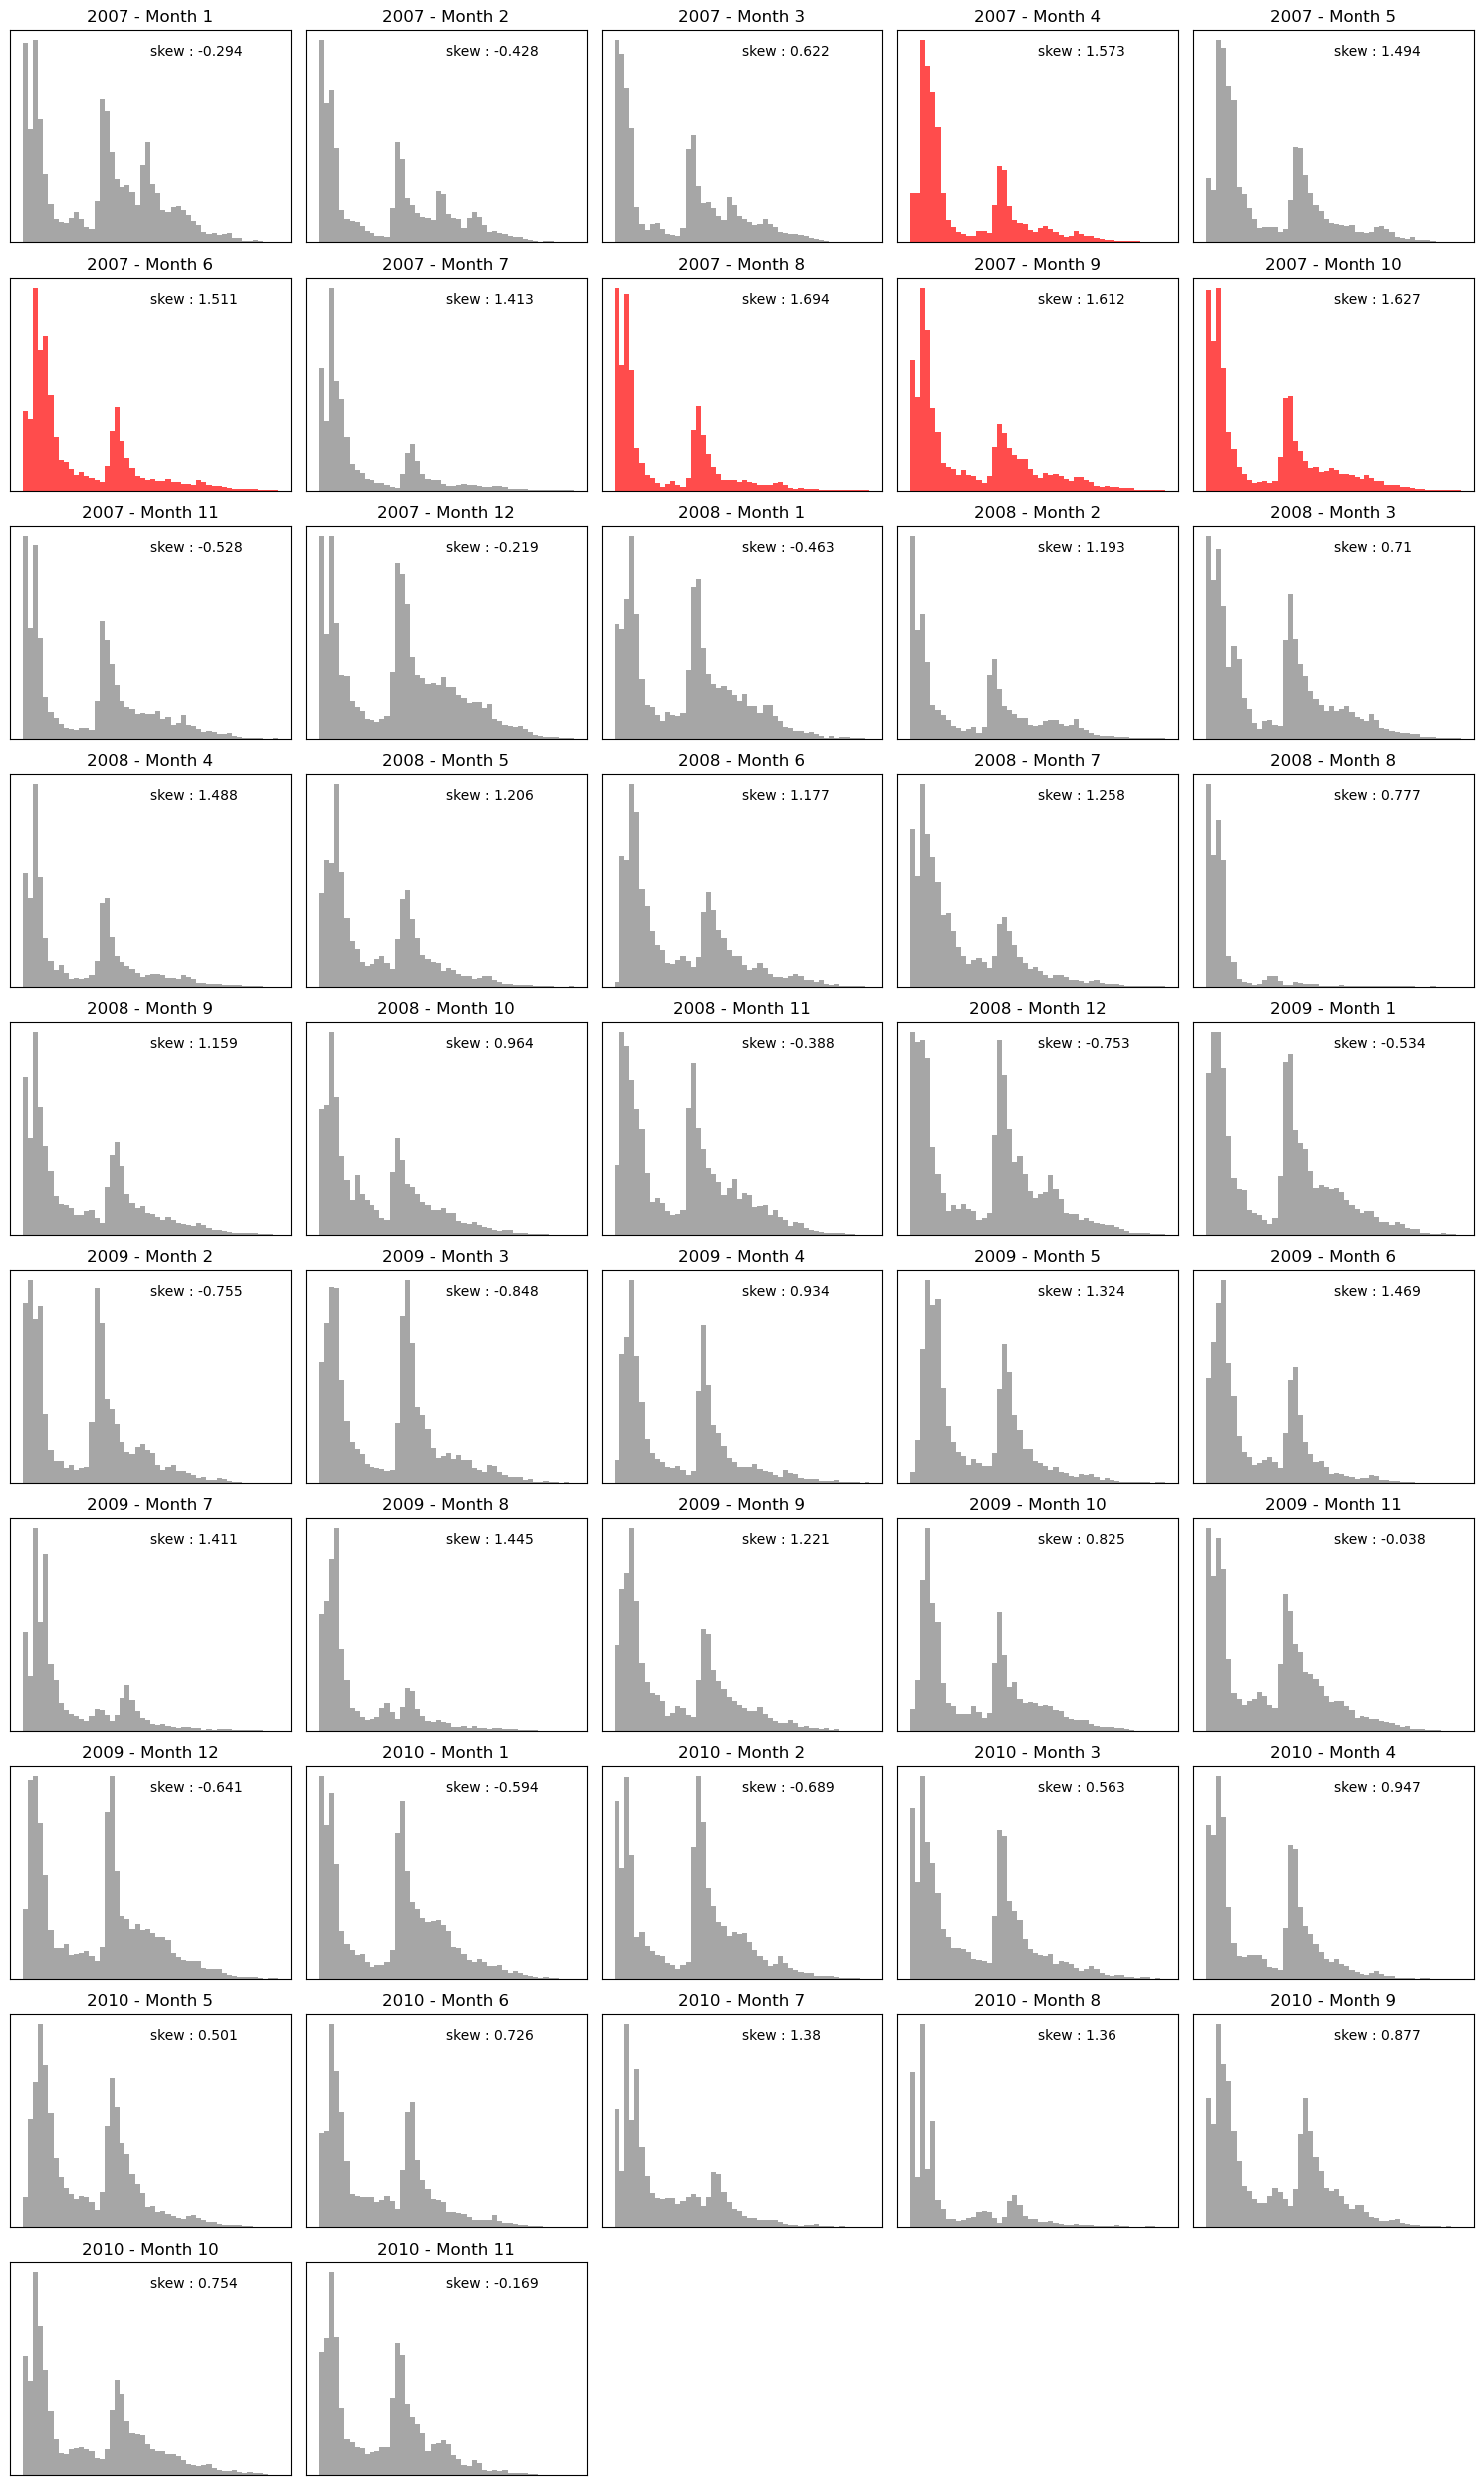

In [ ]:
# 그래프 설정
fig = plt.figure(figsize=(15, 40))

# 2007년부터 2010년까지 각 연도의 월별 서브플롯 생성
for year in range(2007, 2011):
    for month in range(1, 13):
        if year == 2010 and month > 11:
            break
        ax = plt.subplot(16, 5, (year - 2007) * 12 + month)
        monthly_data = df[(df['Year'] == year) & (df['Month'] == month)]['Global_active_power'].dropna()

        # 로그 변환 적용 (np.log1p는 log(1 + x)를 계산)
        monthly_data_log = np.log1p(monthly_data)
        mean = monthly_data_log.mean()
        std = monthly_data_log.std()

        # std가 NaN인 경우 0으로 처리
        mean = round(mean, 3) if not np.isnan(mean) else 0
        std = round(std, 3) if not np.isnan(std) else 0
        skew = 0 if std == 0 else round((3 * (mean - np.median(monthly_data_log)) / std), 3)

        # 왜도에 따른 히스토그램 색상 설정
        color = 'gray'
        if skew >= 1.5:
            color = 'red'
        elif skew <= -1.5:
            color = 'blue'

        # 히스토그램 그리기
        plt.hist(monthly_data_log, alpha=0.7, bins=50, color=color)
        plt.title(f'{year} - Month {month}')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')
        plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

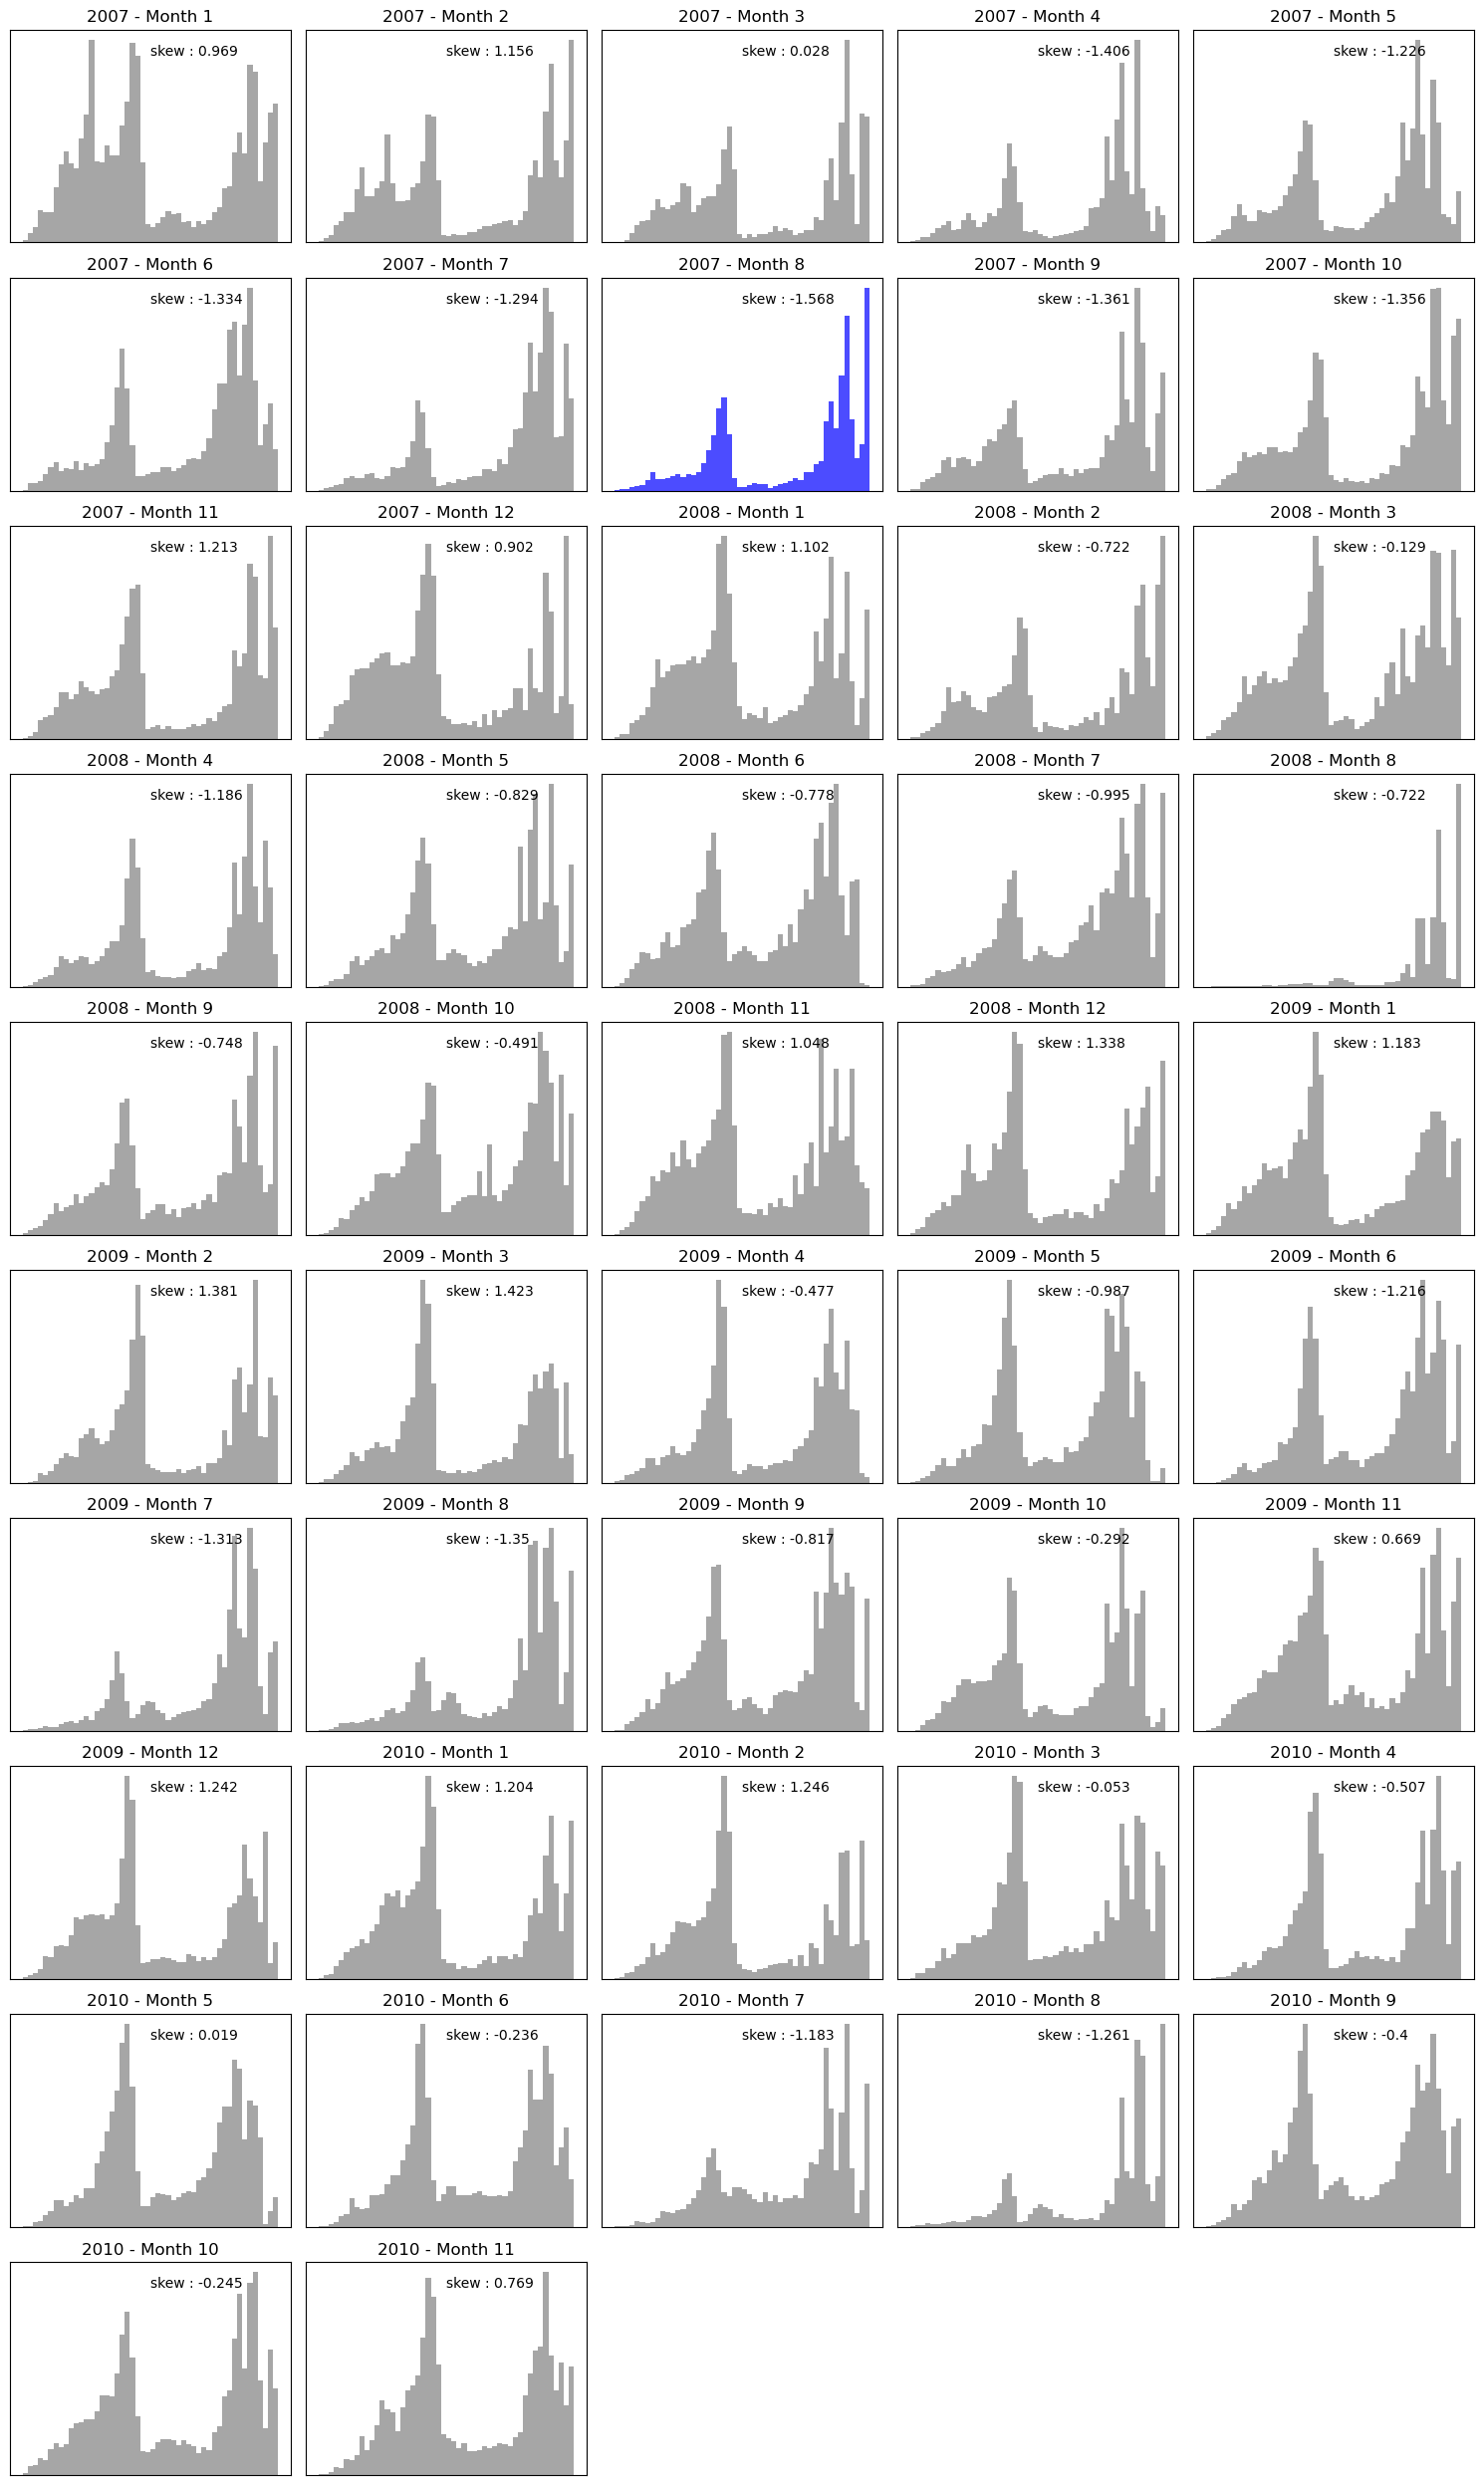

In [ ]:
fig = plt.figure(figsize=(15, 40))

# 2007년부터 2010년까지 각 연도의 월별 서브플롯 생성
for year in range(2007, 2011):
    for month in range(1, 13):
        if year == 2010 and month > 11:
            break
        ax = plt.subplot(16, 5, (year - 2007) * 12 + month)
        monthly_data = df[(df['Year'] == year) & (df['Month'] == month)]['Global_active_power'].dropna()

        # 역수 변환 적용 (0을 피하기 위해 1을 더함)
        monthly_data_reciprocal = 1 / (monthly_data + 1)
        mean = monthly_data_reciprocal.mean()
        std = monthly_data_reciprocal.std()

        # std가 NaN인 경우 0으로 처리
        mean = round(mean, 3) if not np.isnan(mean) else 0
        std = round(std, 3) if not np.isnan(std) else 0
        skew = 0 if std == 0 else round((3 * (mean - np.median(monthly_data_reciprocal)) / std), 3)

        # 왜도에 따른 히스토그램 색상 설정
        color = 'gray'
        if skew >= 1.5:
            color = 'red'
        elif skew <= -1.5:
            color = 'blue'

        # 히스토그램 그리기
        plt.hist(monthly_data_reciprocal, alpha=0.7, bins=50, color=color)
        plt.title(f'{year} - Month {month}')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')
        plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()


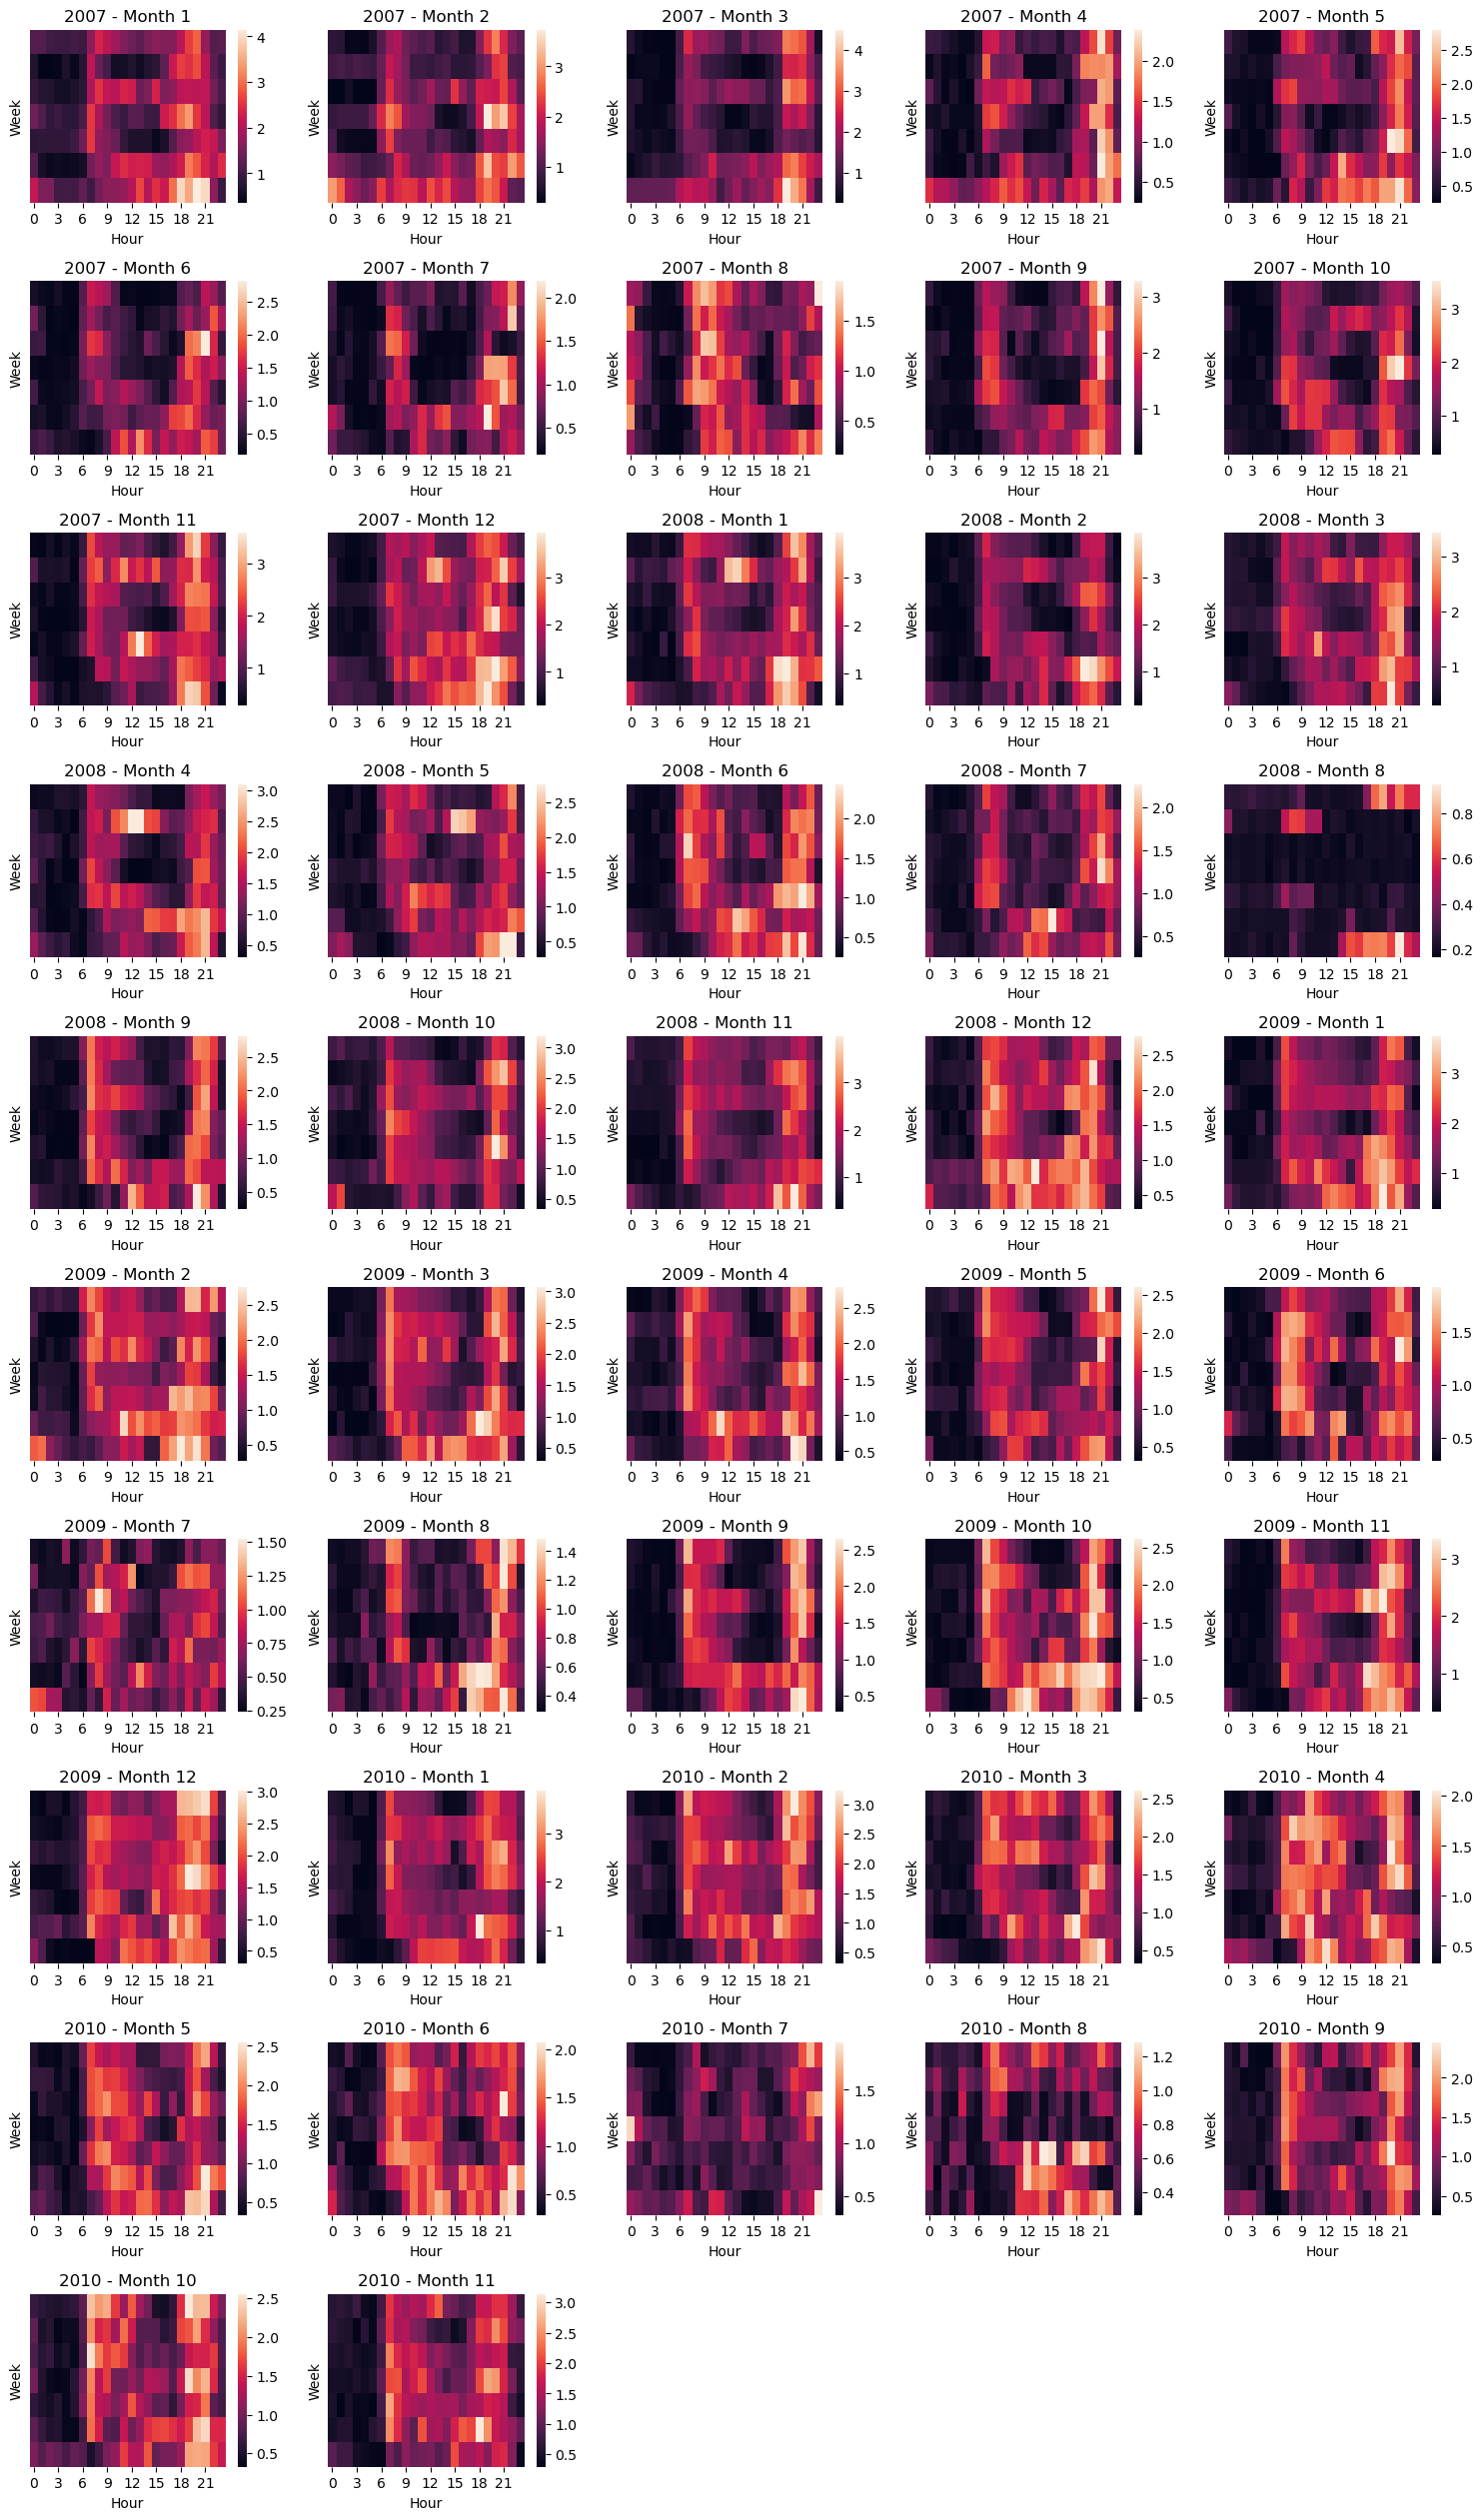

In [ ]:
fig = plt.figure(figsize=(15, 40))

# 2007년부터 2010년까지 각 연도의 월별 히트맵 생성
for year in range(2007, 2011):
    for month in range(1, 13):
        if year == 2010 and month > 11:  # 2010년은 11월까지만 데이터가 있다고 가정
            break
        ax = plt.subplot(16, 5, (year - 2007) * 12 + month)
        monthly_df = df[(df['Year'] == year) & (df['Month'] == month)]
        heatmap_data = monthly_df.groupby(['Week', 'Hour'])['Global_active_power'].mean().unstack()

        sns.heatmap(heatmap_data, ax=ax)
        plt.title(f'{year} - Month {month}')
        plt.xlabel('Hour')
        plt.ylabel('Week')
        plt.yticks([])

plt.tight_layout()
plt.show()

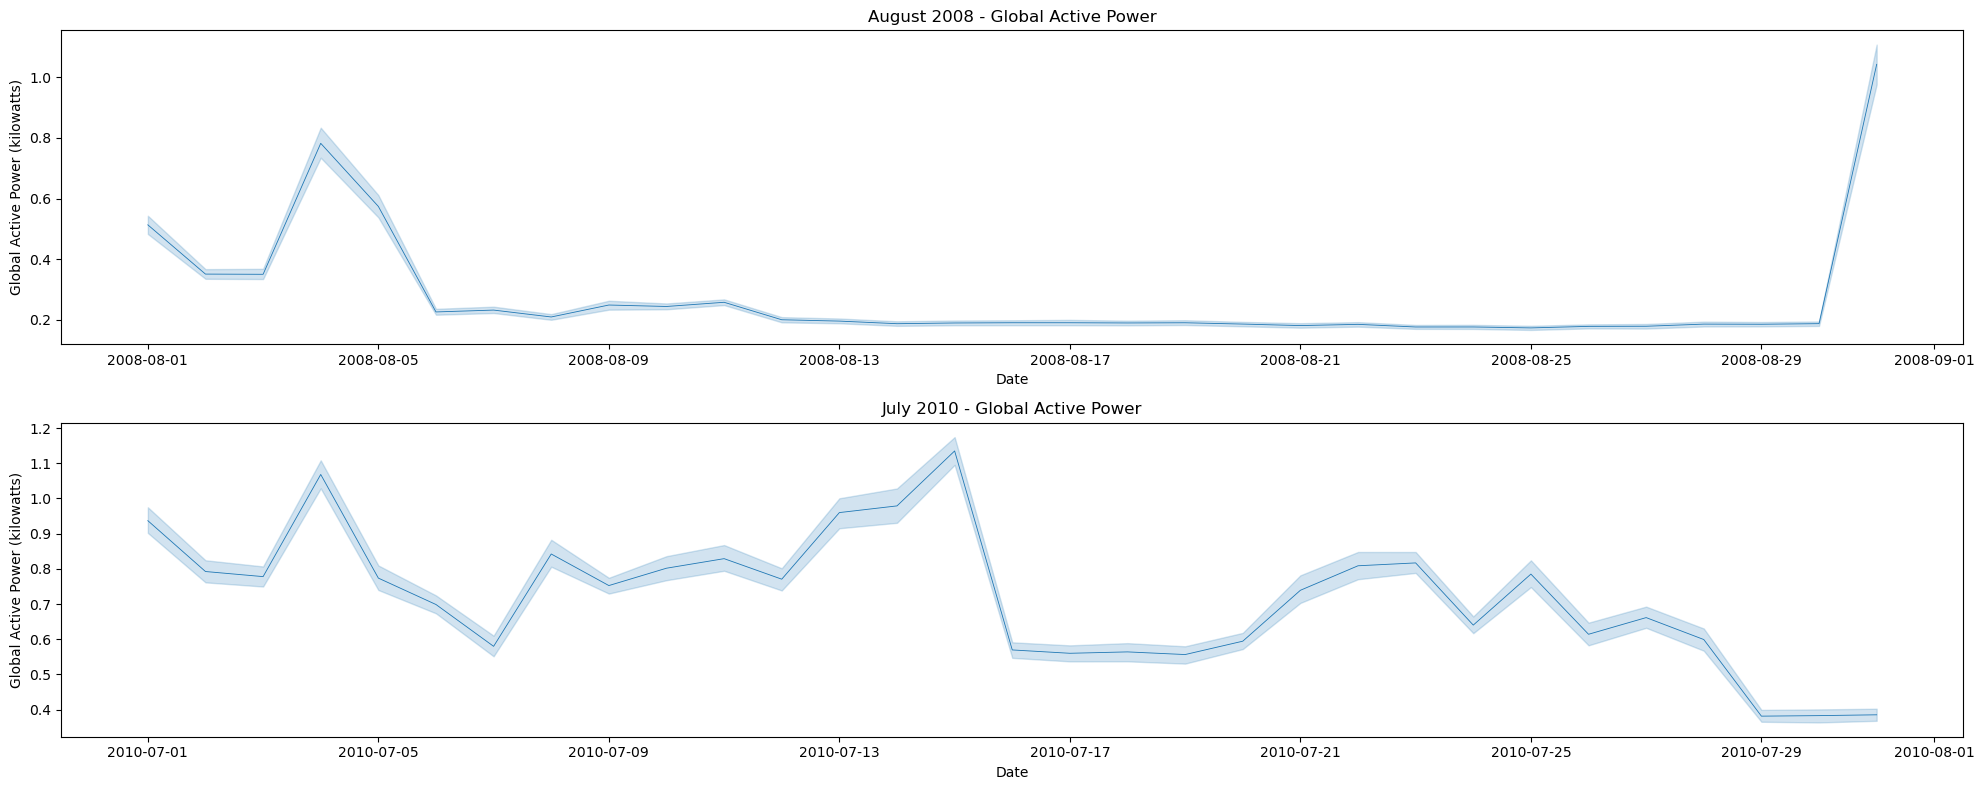

In [ ]:
# 2008년 8월과 2010년 7월 데이터 필터링
aug_2008 = df[(df['Date'].dt.year == 2008) & (df['Date'].dt.month == 8)]
jul_2010 = df[(df['Date'].dt.year == 2010) & (df['Date'].dt.month == 7)]

# 그래프 설정
fig = plt.figure(figsize=(20, 8))

# 2008년 8월 데이터 시각화
plt.subplot(211)
sns.lineplot(data=aug_2008, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('August 2008 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2010년 7월 데이터 시각화
plt.subplot(212)
sns.lineplot(data=jul_2010, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('July 2010 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

plt.tight_layout()
plt.show()

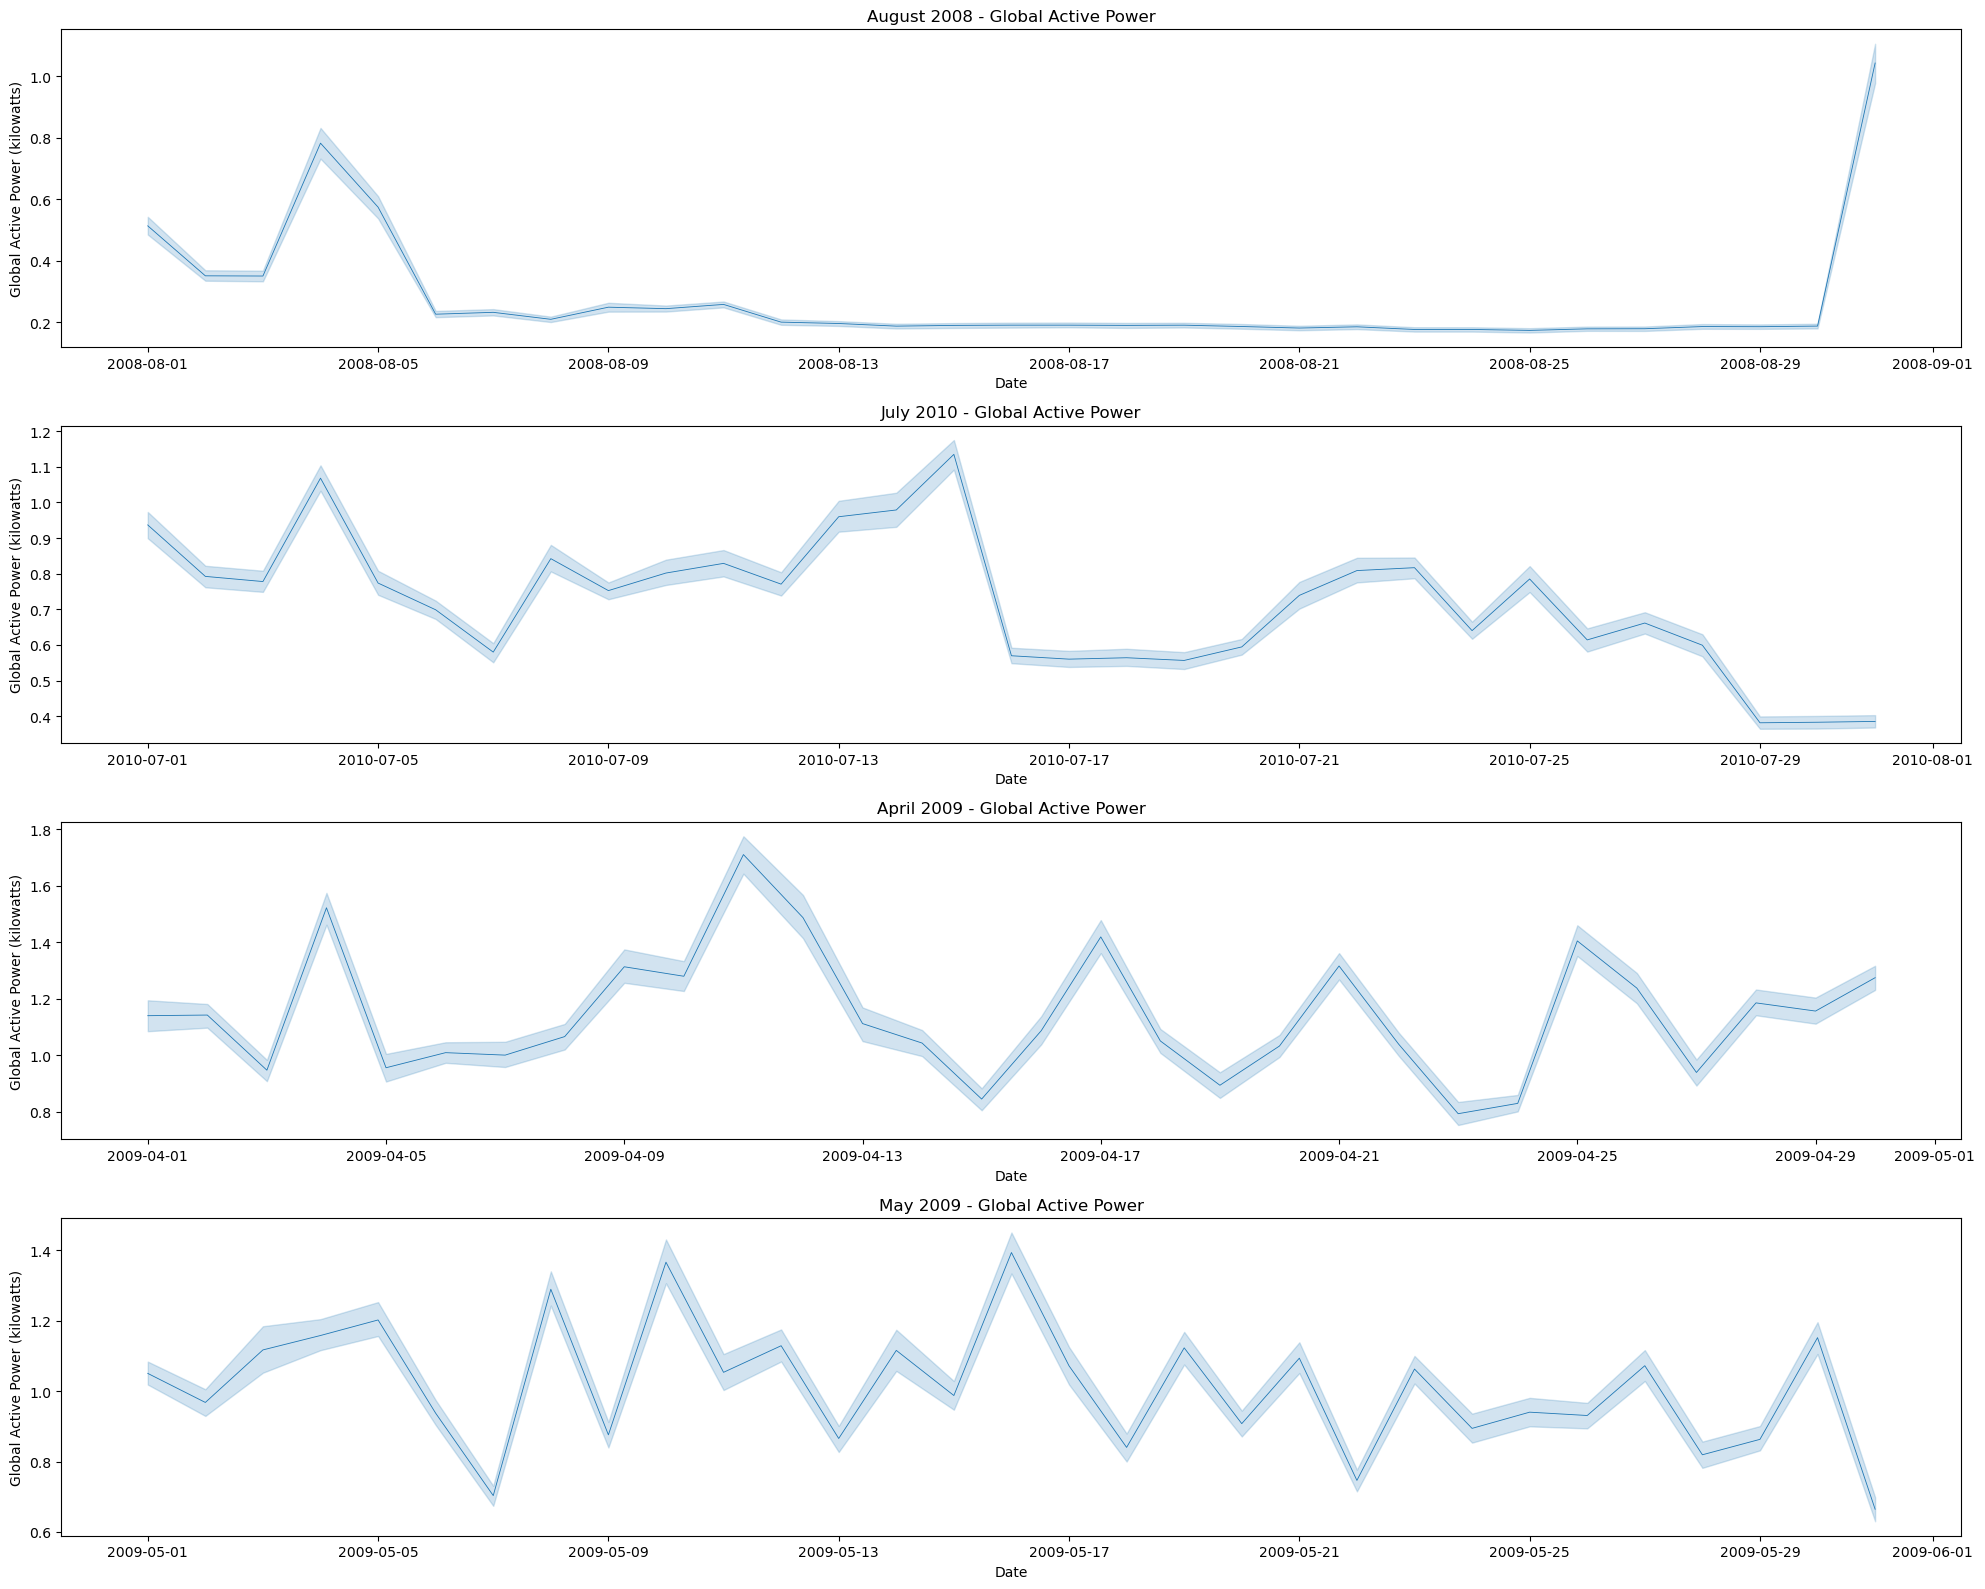

In [ ]:
# 필요한 연도와 월 데이터 필터링
aug_2008 = df[(df['Year'] == 2008) & (df['Month'] == 8)]
jul_2010 = df[(df['Year'] == 2010) & (df['Month'] == 7)]
apr_2009 = df[(df['Year'] == 2009) & (df['Month'] == 4)]
may_2009 = df[(df['Year'] == 2009) & (df['Month'] == 5)]

# 그래프 설정
fig = plt.figure(figsize=(20, 16))

# 2008년 8월 데이터 시각화
plt.subplot(411)
sns.lineplot(data=aug_2008, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('August 2008 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2010년 7월 데이터 시각화
plt.subplot(412)
sns.lineplot(data=jul_2010, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('July 2010 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2009년 4월 데이터 시각화
plt.subplot(413)
sns.lineplot(data=apr_2009, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('April 2009 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2009년 5월 데이터 시각화
plt.subplot(414)
sns.lineplot(data=may_2009, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('May 2009 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

plt.tight_layout()
plt.show()

In [ ]:
# 이상치를 주변 월의 평균값으로 대체하는 함수
def replace_outliers(data, year, month, threshold=0.8):
    # 해당 연도와 월의 데이터 필터링
    specific_month_data = data[(data['Date'].dt.year == year) & (data['Date'].dt.month == month)]

    # 이상치 식별
    outliers = specific_month_data['Global_active_power'] <= threshold

    # 이전 및 다음 월의 평균값 계산
    prev_month_mean = data[(data['Date'].dt.year == year) & (data['Date'].dt.month == month - 1)]['Global_active_power'].mean()
    next_month_mean = data[(data['Date'].dt.year == year) & (data['Date'].dt.month == month + 1)]['Global_active_power'].mean()
    neighboring_months_mean = np.nanmean([prev_month_mean, next_month_mean])

    # 이상치를 주변 월 평균값으로 대체
    data.loc[(data['Date'].dt.year == year) & (data['Date'].dt.month == month) & outliers, 'Global_active_power'] = neighboring_months_mean

# 2008년 8월과 2010년 7월의 이상치 처리
replace_outliers(df, 2008, 8)
replace_outliers(df, 2010, 7)

# 결과 확인
print(df[(df['Date'].dt.year == 2008) & (df['Date'].dt.month == 8)].head())
print(df[(df['Date'].dt.year == 2010) & (df['Date'].dt.month == 7)].head())

           Date      Time  Global_active_power  Global_reactive_power  \
5076 2008-08-02  17:00:00             0.891231                  0.234   
5077 2008-08-02  17:01:00             0.891231                  0.236   
5078 2008-08-02  17:02:00             0.891231                  0.236   
5079 2008-08-02  17:03:00             0.891231                  0.236   
5080 2008-08-02  17:04:00             0.891231                  0.234   

      Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
5076   241.19               1.6             0.0             0.0   
5077   241.31               1.6             0.0             0.0   
5078   241.42               1.6             0.0             0.0   
5079   241.58               1.6             0.0             0.0   
5080   241.33               1.6             0.0             0.0   

      Sub_metering_3  Hour  Week  Month  Year  Global_active_power_mean  \
5076             1.0    17     5      8  2008                  1.576265   
5077    

In [ ]:
# 필요한 연도와 월 데이터 필터링
aug_2008 = df[(df['Year'] == 2008) & (df['Month'] == 8)]
jul_2010 = df[(df['Year'] == 2010) & (df['Month'] == 7)]
apr_2009 = df[(df['Year'] == 2009) & (df['Month'] == 4)]
may_2009 = df[(df['Year'] == 2009) & (df['Month'] == 5)]

# 그래프 설정
fig = plt.figure(figsize=(20, 16))

# 2008년 8월 데이터 시각화
plt.subplot(411)
sns.lineplot(data=aug_2008, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('August 2008 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2010년 7월 데이터 시각화
plt.subplot(412)
sns.lineplot(data=jul_2010, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('July 2010 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2009년 4월 데이터 시각화
plt.subplot(413)
sns.lineplot(data=apr_2009, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('April 2009 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2009년 5월 데이터 시각화
plt.subplot(414)
sns.lineplot(data=may_2009, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('May 2009 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

In [ ]:
# 2008년 8월 데이터 삭제
df = df[~((df['Date'].dt.year == 2008) & (df['Date'].dt.month == 8))]
df = df[~((df['Date'].dt.year == 2010) & (df['Date'].dt.month == 7))]
# 결과 확인
print(df.head())

        Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16  17:24:00                4.216                  0.418   234.84   
1 2006-12-16  17:25:00                5.360                  0.436   233.63   
2 2006-12-16  17:26:00                5.374                  0.498   233.29   
3 2006-12-16  17:27:00                5.388                  0.502   233.74   
4 2006-12-16  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  Hour  \
0              18.4             0.0             1.0            17.0    17   
1              23.0             0.0             1.0            16.0    17   
2              23.0             0.0             2.0            17.0    17   
3              23.0             0.0             1.0            17.0    17   
4              15.8             0.0             1.0            17.0    17   

   Week  Month  Year  Global_active_power_mean  Global_active_

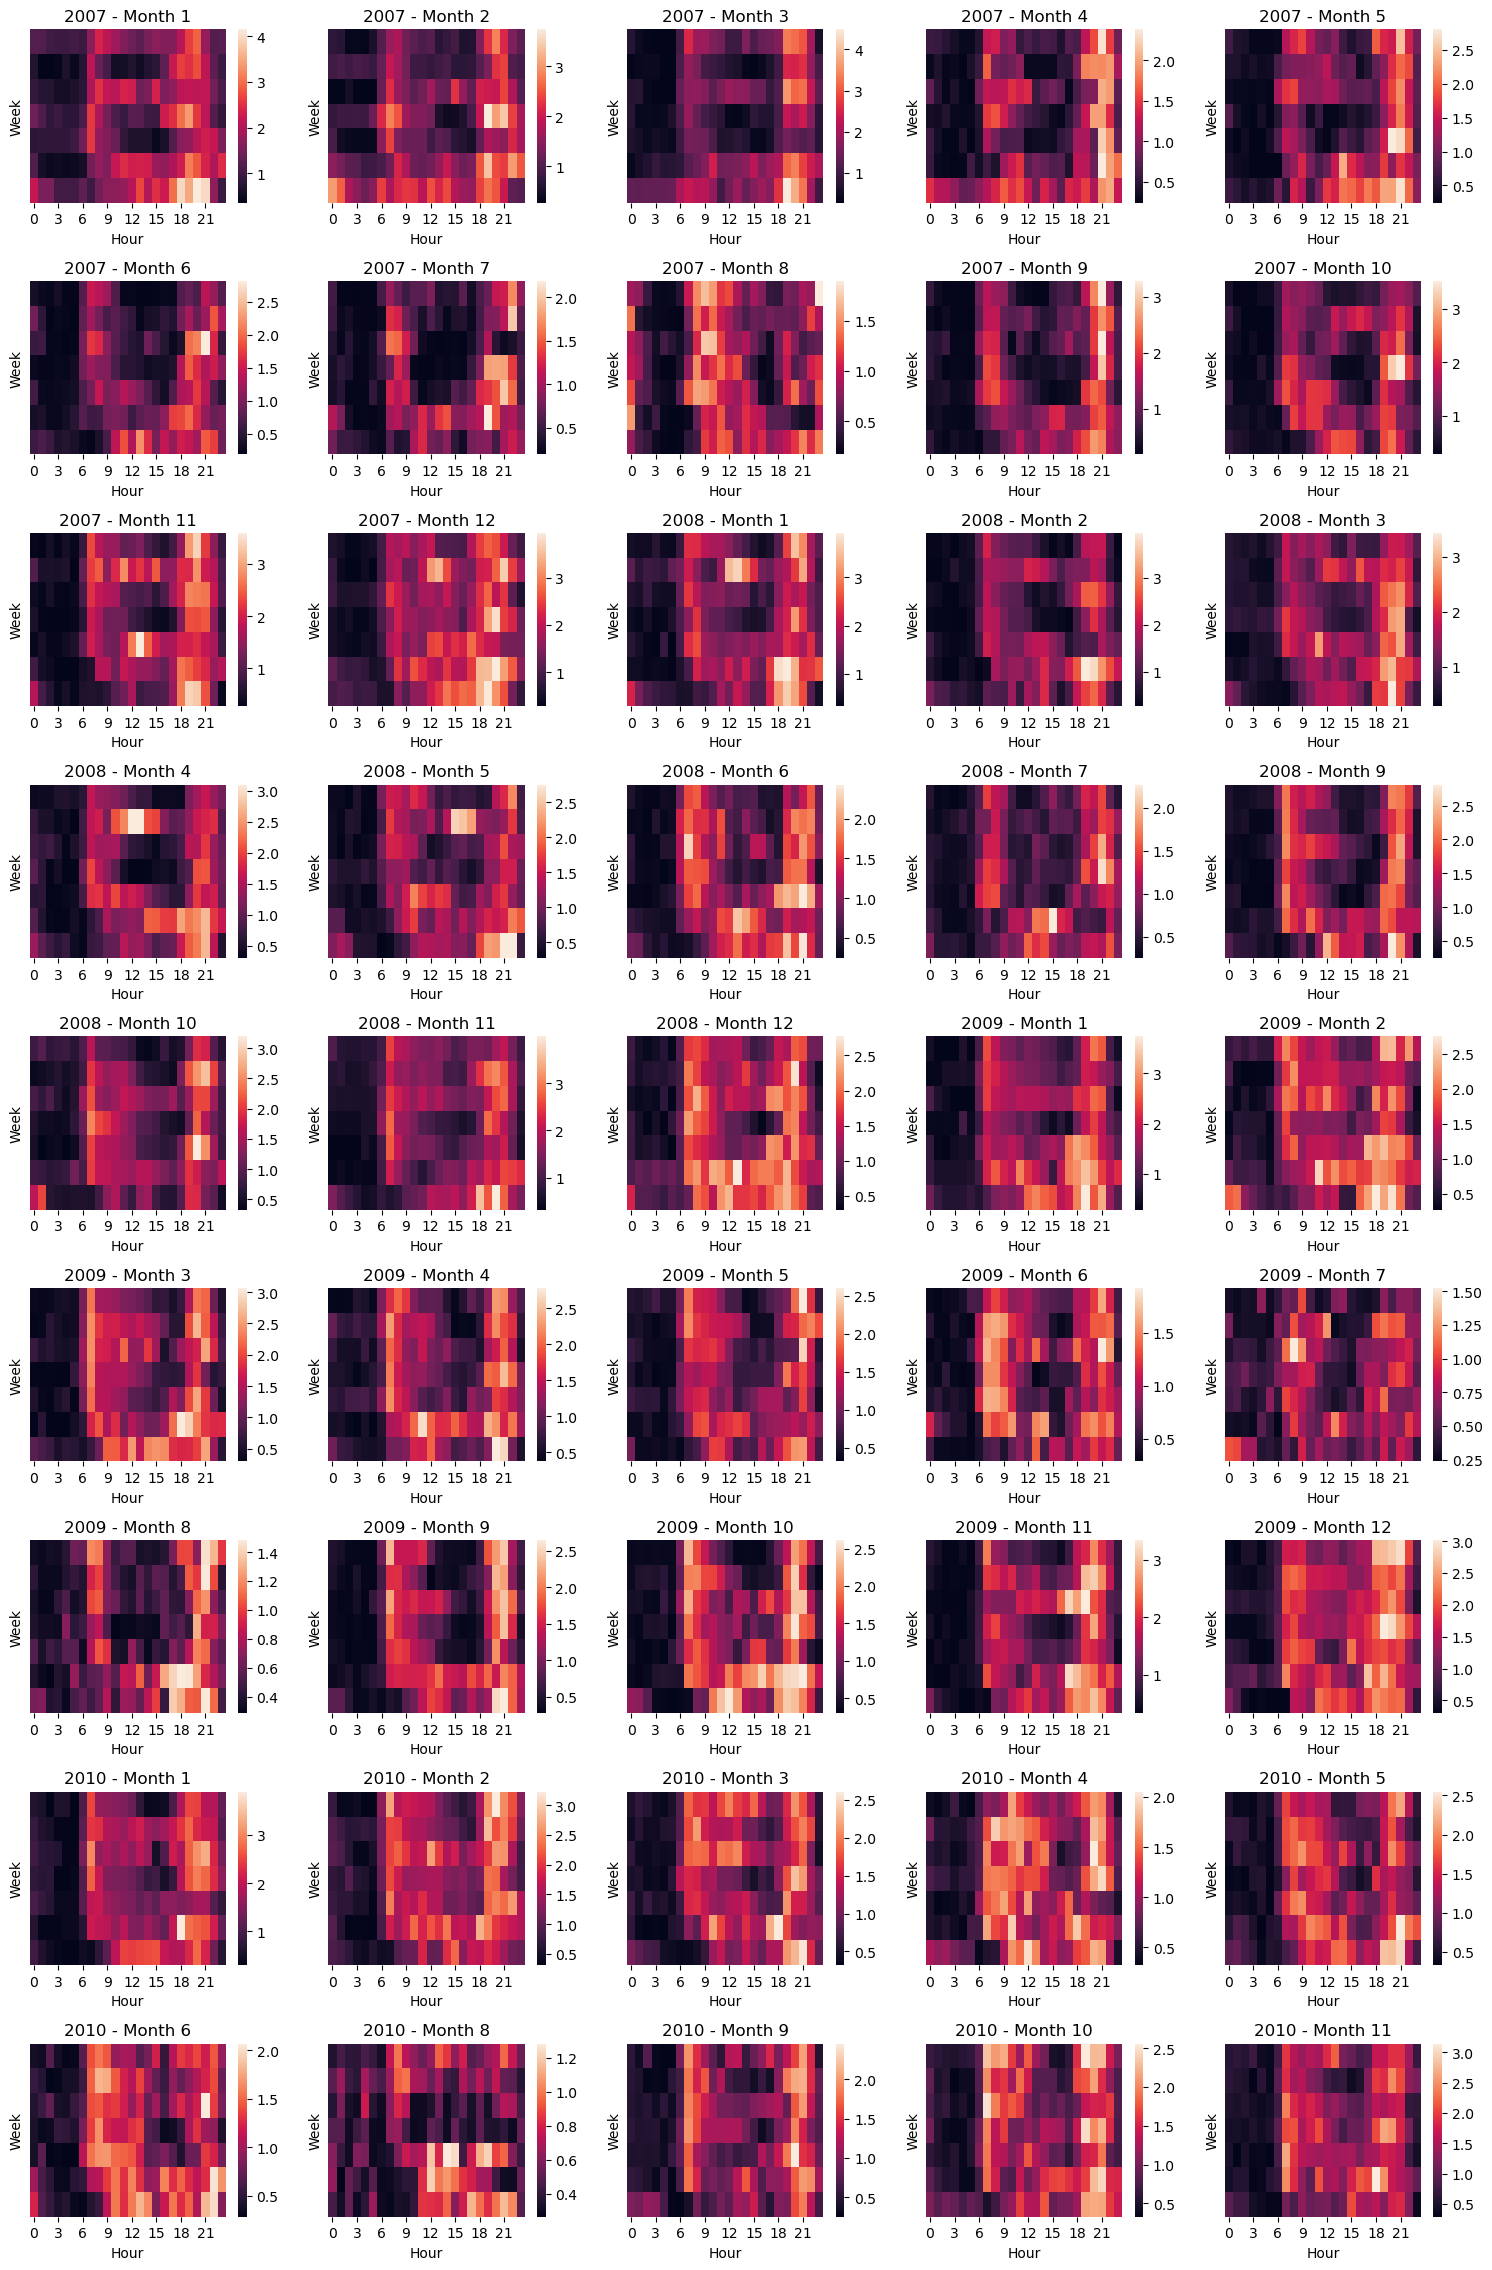

In [ ]:
fig = plt.figure(figsize=(15, 40))

# 2007년부터 2010년까지 각 연도의 월별 히트맵 생성
subplot_num = 1  # 서브플롯 번호 초기화
for year in range(2007, 2011):
    for month in range(1, 13):
        # 2010년은 11월까지만 데이터가 있다고 가정
        if year == 2010 and month > 11:
            break

        # 2008년 8월과 2010년 7월 데이터를 건너뛰기
        if (year == 2008 and month == 8) or (year == 2010 and month == 7):
            continue

        ax = plt.subplot(16, 5, subplot_num)
        monthly_df = df[(df['Year'] == year) & (df['Month'] == month)]
        heatmap_data = monthly_df.groupby(['Week', 'Hour'])['Global_active_power'].mean().unstack()

        sns.heatmap(heatmap_data, ax=ax)
        plt.title(f'{year} - Month {month}')
        plt.xlabel('Hour')
        plt.ylabel('Week')
        plt.yticks([])

        subplot_num += 1  # 서브플롯 번호 증가

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.dates as mdates

# 데이터 로드 및 정제 과정 (이미 수행한 것으로 가정)

# 날짜 범위 설정 (2007년 1월부터 2010년 11월까지)
start_date = '2007-01-01'
end_date = '2010-11-30'
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

# 마지막 1달을 검증 세트로 설정
last_month = df['DateTime'].max() - pd.DateOffset(months=1)
train_df = df[df['DateTime'] <= last_month]
valid_df = df[df['DateTime'] > last_month]

# 전처리된 데이터 저장
train_df.to_csv('power_train.csv', index=False)
valid_df.to_csv('power_valid.csv', index=False)

# 데이터 shape 출력
print('Train data shape:', train_df.shape)
print('Validation data shape:', valid_df.shape)

Train data shape: (1919343, 17)
Validation data shape: (44640, 17)


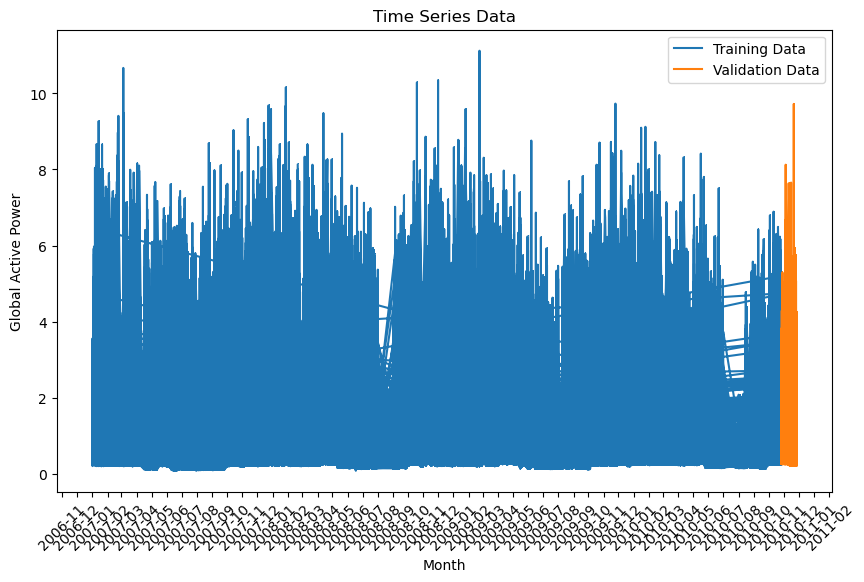

In [ ]:
# 타겟 변수 설정
y_train = train_df['Global_active_power']
y_valid = valid_df['Global_active_power']

# 특성 데이터 설정 (Date와 Time 컬럼 제거)
x_train = train_df.drop(['Global_active_power', 'DateTime', 'Date', 'Time'], axis=1)
x_valid = valid_df.drop(['Global_active_power', 'DateTime', 'Date', 'Time'], axis=1)

# 시계열 데이터 시각화
def plot_series(train_index, valid_index, y_train, y_valid, markers):
    plt.figure(figsize=(10, 6))
    plt.plot(train_index, y_train, marker=markers[0], label='Training Data')
    plt.plot(valid_index, y_valid, marker=markers[1], label='Validation Data')
    plt.title('Time Series Data')
    plt.xlabel('Month')
    plt.ylabel('Global Active Power')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

plot_series(train_df['DateTime'], valid_df['DateTime'], y_train, y_valid, markers=[',' , ','])

In [ ]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [ ]:
print("실제값이 100일 때 50으로 underestimate할 때의 SMAPE : {}".format(SMAPE(100, 50)))
print("실제값이 100일 때 150으로 overestimate할 때의 SMAPE : {}".format(SMAPE(100, 150)))

실제값이 100일 때 50으로 underestimate할 때의 SMAPE : 33.33333333333333
실제값이 100일 때 150으로 overestimate할 때의 SMAPE : 20.0


In [ ]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [ ]:
# 하이퍼파라미터 로드
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb.csv')

# 데이터셋에서 NaN 및 무한대 값을 제거하는 함수
def remove_nan_and_inf(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

# y_train, y_valid, x_train, x_valid에서 NaN 및 무한대 값을 제거
y_train_cleaned = remove_nan_and_inf(y_train.copy())
y_valid_cleaned = remove_nan_and_inf(y_valid.copy())
x_train_cleaned = remove_nan_and_inf(x_train.copy())
x_valid_cleaned = remove_nan_and_inf(x_valid.copy())

# XGBoost 모델 생성 및 훈련
xgb_reg = XGBRegressor(
    n_estimators=10000,
    eta=xgb_params.iloc[47,1],
    min_child_weight=xgb_params.iloc[47,2],
    max_depth=int(xgb_params.iloc[47,3]),
    colsample_bytree=xgb_params.iloc[47,4],
    subsample=xgb_params.iloc[47,5],
    seed=0,
    early_stopping_rounds=300  # 여기에 추가
)

xgb_reg.fit(x_train_cleaned, y_train_cleaned, eval_set=[(x_train_cleaned, y_train_cleaned), (x_valid_cleaned, y_valid_cleaned)],
            verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=300,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

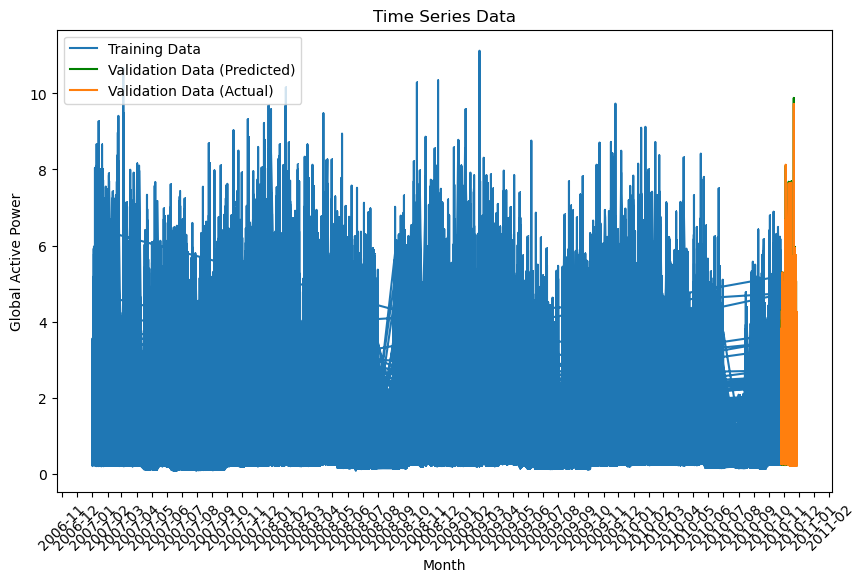

best iterations: 9999
SMAPE : 2.5176500337085606


In [ ]:
# 예측 수행
pred = xgb_reg.predict(x_valid)
pred_series = pd.Series(pred, index=valid_df['DateTime'])

# 시계열 데이터 시각화
def plot_series(train_index, valid_index, y_train, y_valid, y_pred, markers):
    plt.figure(figsize=(10, 6))
    plt.plot(train_index, y_train, marker=markers[0], label='Training Data')
    plt.plot(valid_index, y_pred, marker=markers[2], color='green', label='Validation Data (Predicted)')
    plt.plot(valid_index, y_valid, marker=markers[1], label='Validation Data (Actual)')
    plt.title('Time Series Data')
    plt.xlabel('Month')
    plt.ylabel('Global Active Power')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

plot_series(train_df['DateTime'], valid_df['DateTime'], y_train, y_valid, pred_series, markers=[',' , ',', ','])

# SMAPE 함수 정의
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 결과 출력
print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid_cleaned, pred)))

In [ ]:
#cuda 사용 가능 여부
import torch

print(torch.cuda.is_available())


#train.py 실행 시 GPU 사용 여부 체크
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Training on GPU {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Training on CPU')

False
Training on CPU


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow.keras'

In [ ]:
# 데이터 스케일링 (MinMaxScaler 사용)
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

# LSTM-AE에 맞게 데이터 형태 변환
# 예: 시퀀스 길이를 60으로 설정
sequence_length = 60

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data)-seq_length):
        xs.append(data[i:(i+seq_length)])
    return np.array(xs)

X_train_seq = create_sequences(x_train_scaled, sequence_length)
X_valid_seq = create_sequences(x_valid_scaled, sequence_length)

In [ ]:
# 모델 구성
model = Sequential()

# 인코더 부분
model.add(LSTM(32, input_shape=(sequence_length, X_train_seq.shape[2]), return_sequences=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(RepeatVector(sequence_length))  # 타임 스텝 수를 RepeatVector의 인자로 사용

# 디코더 부분
model.add(LSTM(32, return_sequences=True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(X_train_seq.shape[2])))  # 특성 수를 Dense의 인자로 사용

# 그라디언트 클리핑을 적용한 Adam 옵티마이저
adam = Adam(learning_rate=0.001, clipvalue=1.0)

# 모델 컴파일
model.compile(optimizer=adam, loss='mse', metrics=[MeanAbsoluteError()])

# 모델 요약
model.summary()

In [ ]:

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_seq,
    X_train_seq,  # Autoencoder는 입력 데이터를 타겟 데이터로 사용
    epochs=100,
    batch_size=64,
    validation_data=(X_valid_seq, X_valid_seq),
    verbose=1,
    callbacks=[early_stopping]  # 조기 종료 콜백 추가
)

In [ ]:
# 훈련 및 검증 손실 시각화
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 재구성 오차 계산 (이상 탐지를 위해)
reconstructed = model.predict(X_valid_seq)
mse = np.mean(np.power(X_valid_seq - reconstructed, 2), axis=1)

# 임계값 설정 및 이상 탐지
threshold = np.quantile(mse, 0.99)  # 예: 99% 분위수를 임계값으로 설정
anomalies = mse > threshold

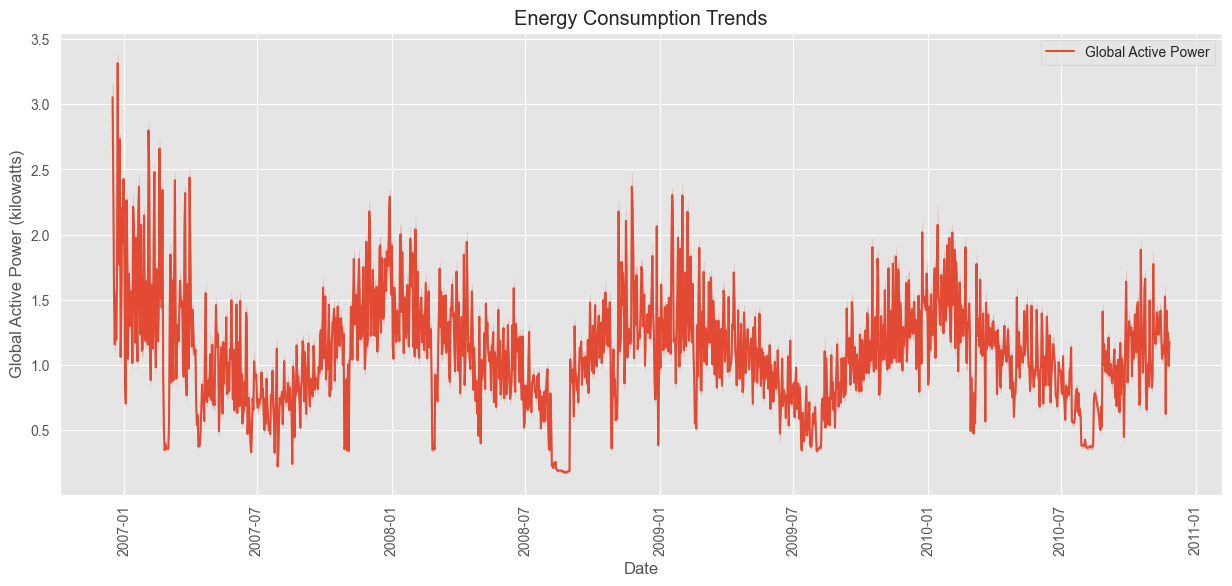

In [ ]:
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns

# 멀티인덱스를 가진 데이터프레임에서 'Date'와 'Time' 인덱스를 컬럼으로 변환
dataset_reset = dataset.reset_index()

style.use('ggplot')

# 그래프 설정
plt.figure(figsize=(15,6))

# 선 그래프 그리기
# 'Date' 컬럼을 x축으로, 'Global_active_power' 컬럼을 y축으로 사용
# label 매개변수를 사용하여 레이블 지정
sns.lineplot(data=dataset_reset, x="Date", y="Global_active_power", label='Global Active Power')

plt.title("Energy Consumption Trends")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.grid(True)
plt.legend()  # 이제 올바른 레이블이 지정되었으므로 범례가 정상적으로 표시됩니다.

# x축 레이블 회전
plt.xticks(rotation=90)

plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_24232\1323515809.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["Global_active_power"].dropna(), kde=True, color='blue')


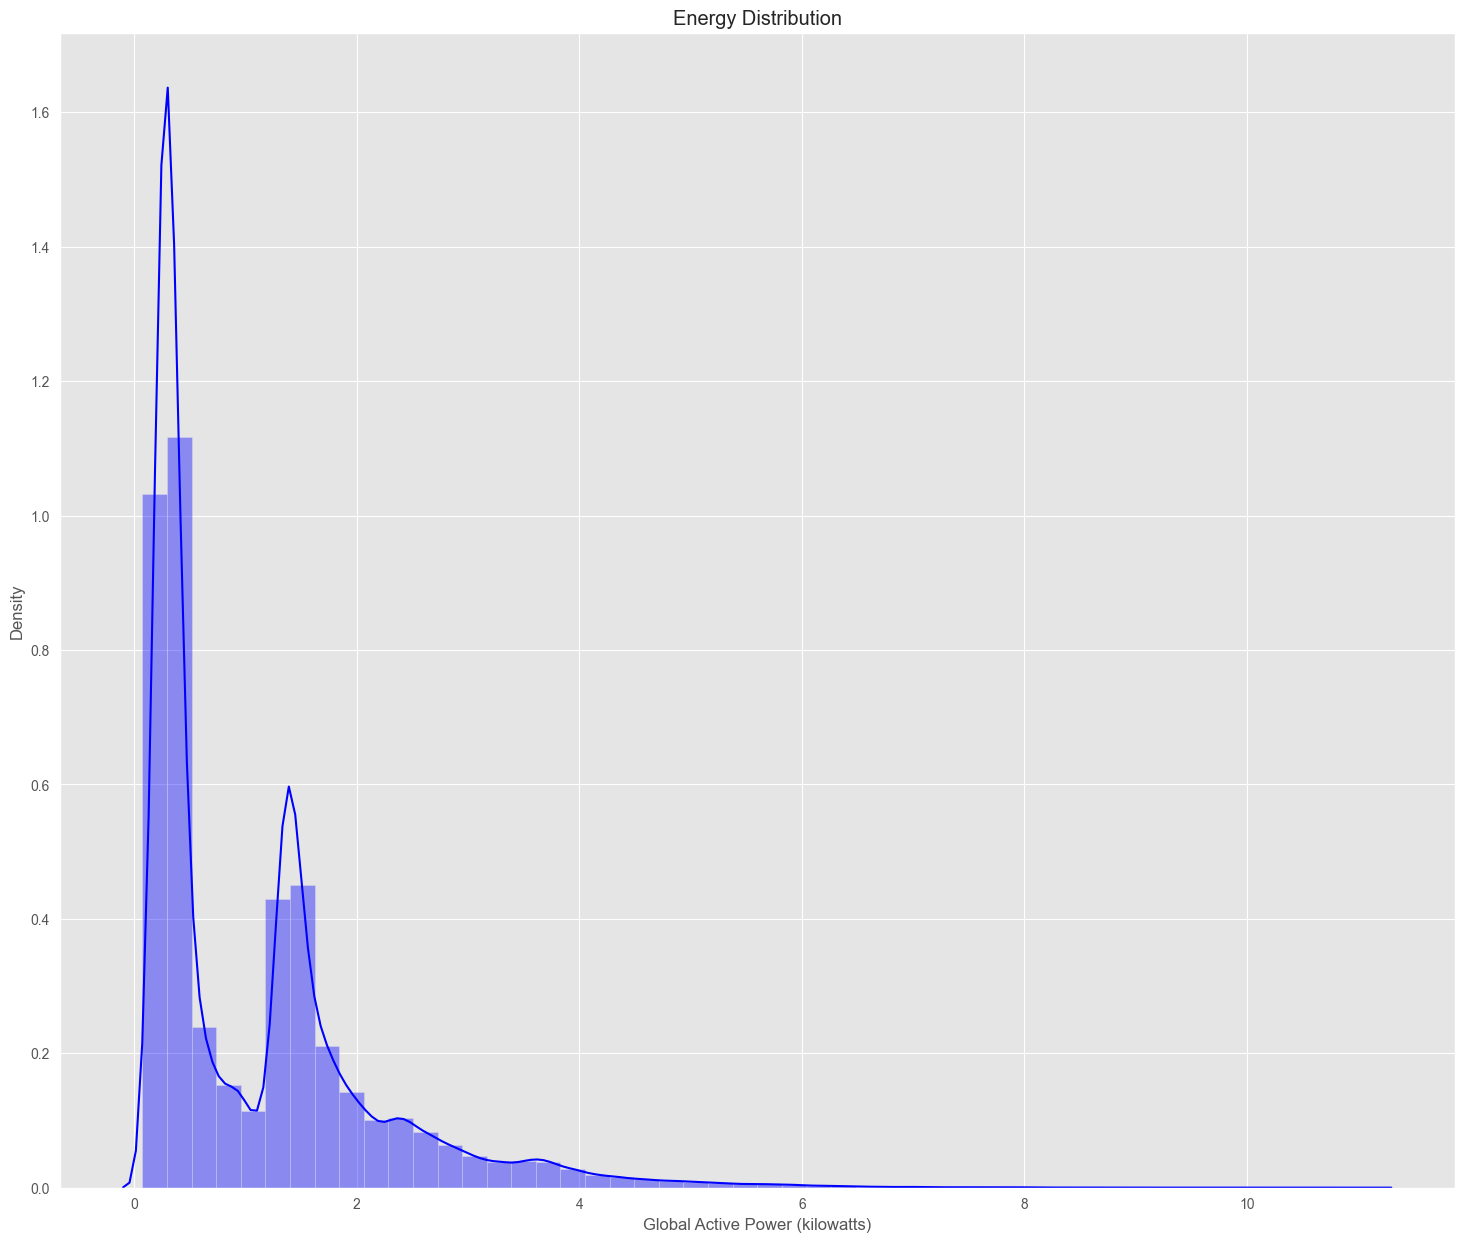

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Global_active_power 컬럼의 분포를 시각화
sns.distplot(dataset["Global_active_power"].dropna(), kde=True, color='blue')
plt.title("Energy Distribution")
plt.xlabel("Global Active Power (kilowatts)")
plt.ylabel("Density")
plt.show()


In [ ]:
dataset = pd.read_csv("power.csv", low_memory=False)

In [ ]:
# 'Date' 컬럼을 datetime 타입으로 변환
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d/%m/%Y')

# 'Year' 컬럼 생성
dataset['Year'] = dataset['Date'].dt.year

# 'Time' 컬럼을 datetime.time 객체로 변환 (24시간제 형식)
dataset['Time'] = pd.to_datetime(dataset['Time'], format='%H:%M:%S').dt.time

# 'Time' 컬럼을 문자열로 변환 (예: 'HH:MM' 형식)
dataset['Time_str'] = dataset['Time'].apply(lambda t: t.strftime('%H:%M'))

In [ ]:
# '?' 값을 NaN으로 대체
dataset['Global_active_power'] = dataset['Global_active_power'].replace('?', np.nan)

dataset['Global_active_power'] = dataset['Global_active_power'].astype(float)
mean_value = dataset['Global_active_power'].mean()
dataset['Global_active_power'].fillna(mean_value, inplace=True)

dataset.dropna(subset=['Global_active_power'], inplace=True)

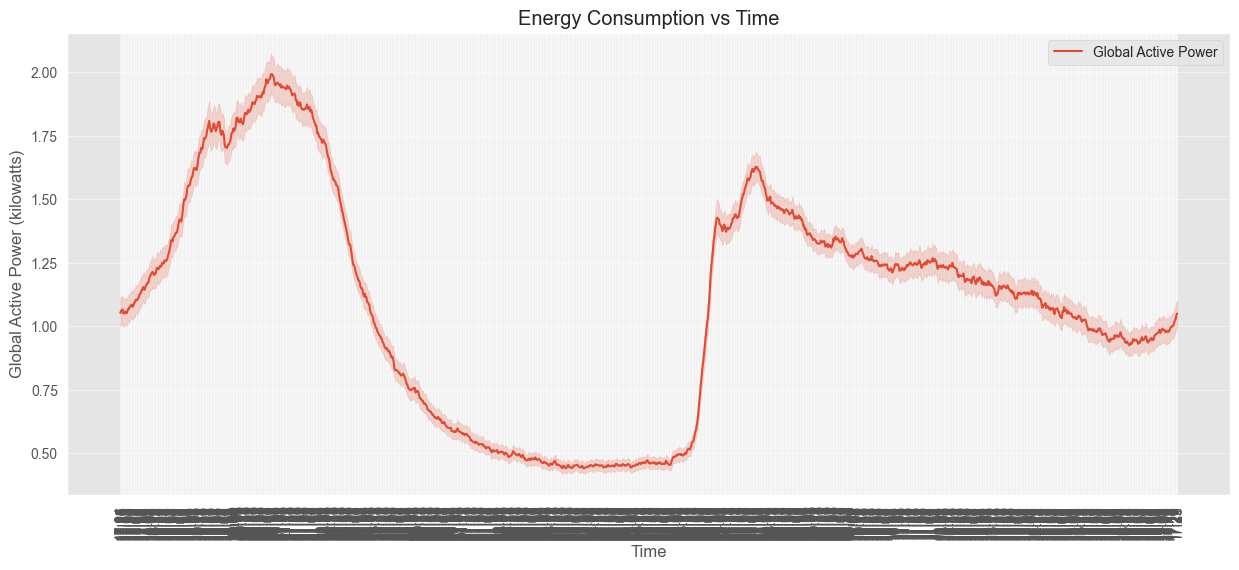

In [ ]:
# 그래프 설정
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)

# 시간별 Global_active_power 데이터 시각화
sns.lineplot(data=dataset, x="Time_str", y="Global_active_power")

plt.title("Energy Consumption vs Time")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kilowatts)")
plt.grid(True, alpha=0.5)  # 그리드 투명도 조정
plt.legend(labels=['Global Active Power'])

# x축 레이블 회전
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

plt.show()

In [ ]:
Q1 = dataset['Global_active_power'].quantile(0.25)
Q3 = dataset['Global_active_power'].quantile(0.75)
IQR = Q3 - Q1

# 이상치의 인덱스를 찾음
outliers = dataset[(dataset['Global_active_power'] < (Q1 - 1.5 * IQR)) | (dataset['Global_active_power'] > (Q3 + 1.5 * IQR))].index
print("Number of outliers:", len(outliers))
print("Outliers index:", outliers)


Number of outliers: 96742
Outliers index: Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            2074568, 2074569, 2074570, 2074571, 2074572, 2074573, 2074574,
            2074575, 2074576, 2074577],
           dtype='int64', length=96742)


In [ ]:
# 이상치를 제거
dataset_cleaned = dataset.drop(outliers)

# 결과 확인
print("Original dataset shape:", dataset.shape)
print("Cleaned dataset shape:", dataset_cleaned.shape)

Original dataset shape: (2075259, 11)
Cleaned dataset shape: (1978517, 11)


In [ ]:
print(dataset.columns)

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Year', 'Time_str'],
      dtype='object')


In [ ]:
print(dataset['Global_active_power'].isnull().sum())

0


In [ ]:
print(dataset['Time_str'].head())
print(dataset['Global_active_power'].head())

0    17:24
1    17:25
2    17:26
3    17:27
4    17:28
Name: Time_str, dtype: object
0    4.216
1    5.360
2    5.374
3    5.388
4    3.666
Name: Global_active_power, dtype: float64


In [ ]:
dataset = dataset.copy()
dataset['Global_active_power'].interpolate(method='linear', inplace=True)

In [ ]:
# 'Date' 컬럼을 datetime 타입으로 변환
dataset['Date'] = pd.to_datetime(dataset['Date'])

# 'Date' 컬럼을 데이터프레임의 인덱스로 설정
dataset.set_index('Date', inplace=True)

In [ ]:
# 'Year' 컬럼 삭제
if 'Year' in dataset.columns:
    dataset = dataset.drop('Year', axis=1)

# 'Date' 컬럼을 인덱스로 설정
if 'Date' in dataset.columns:
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset.set_index('Date', inplace=True)
# else:
#     print("'Date' 컬럼이 데이터셋에 없습니다.")

# 결과 확인
print(dataset.head())

                Time  Global_active_power Global_reactive_power  Voltage  \
Date                                                                       
2006-12-16  17:24:00                4.216                 0.418  234.840   
2006-12-16  17:25:00                5.360                 0.436  233.630   
2006-12-16  17:26:00                5.374                 0.498  233.290   
2006-12-16  17:27:00                5.388                 0.502  233.740   
2006-12-16  17:28:00                3.666                 0.528  235.680   

           Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  \
Date                                                                        
2006-12-16           18.400          0.000          1.000            17.0   
2006-12-16           23.000          0.000          1.000            16.0   
2006-12-16           23.000          0.000          2.000            17.0   
2006-12-16           23.000          0.000          1.000            17.0   
2006-

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler(feature_range=(0, 1))

# 'Global_active_power' 컬럼 선택 및 스케일링
# 데이터셋이 'Global_active_power' 컬럼만 포함한다고 가정
scaled_data = scaler.fit_transform(dataset[['Global_active_power']])

# 스케일링된 데이터를 DataFrame으로 변환
dataset_scaled = pd.DataFrame(scaled_data, columns=['Global_active_power'])

# 스케일링된 데이터 확인
print(dataset_scaled.head())

   Global_active_power
0             0.374796
1             0.478363
2             0.479631
3             0.480898
4             0.325005


In [ ]:
NewDataSet = dataset.resample('D').mean(numeric_only=True)

In [ ]:
print("Old Dataset ",dataset.shape )
print("New  Dataset ",NewDataSet.shape )

Old Dataset  (2075259, 9)
New  Dataset  (1442, 2)


In [ ]:
TestData = NewDataSet.tail(100)

Training_Set = NewDataSet[['Global_active_power']]

Training_Set = Training_Set[:-60]

In [ ]:
print("Training Set Shape ", Training_Set.shape)
print("Test Set Shape ", TestData.shape)

Training Set Shape  (1382, 1)
Test Set Shape  (100, 2)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

Training_Set = Training_Set[['Global_active_power']].values

sc = MinMaxScaler(feature_range=(0, 1))
Train = sc.fit_transform(Training_Set)

In [ ]:
X_Train = []
Y_Train = []

# 다음 값을 예측하기 위한 데이터셋 생성
for i in range(60, Train.shape[0]):
    X_Train.append(Train[i-60:i])
    Y_Train.append(Train[i])

X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(1322, 60, 1)
(1322, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError

# 모델 구성
model = Sequential()

# 인코더 부분
model.add(LSTM(32, input_shape=(X_Train.shape[1], X_Train.shape[2]), return_sequences=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(RepeatVector(X_Train.shape[1]))  # 타임 스텝 수를 RepeatVector의 인자로 사용

# 디코더 부분
model.add(LSTM(32, return_sequences=True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(X_Train.shape[2])))  # 특성 수를 Dense의 인자로 사용

# 그라디언트 클리핑을 적용한 Adam 옵티마이저
adam = Adam(learning_rate=0.001, clipvalue=1.0)

# 모델 컴파일
model.compile(optimizer=adam, loss='mse', metrics=[MeanAbsoluteError()])

# 모델 요약
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32)                4352      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32)                0         
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 repeat_vector_2 (RepeatVec  (None, 60, 32)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 60, 32)            8320      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 60, 32)            0         
                                                      

In [ ]:
# 결측치가 있는지 확인
if np.any(np.isnan(X_Train)):
    # 결측치를 0으로 대체 (또는 다른 방법을 사용)
    X_Train = np.nan_to_num(X_Train)


In [ ]:
print(np.any(np.isnan(X_Train)))
print(np.any(np.isinf(X_Train)))

False
False


In [ ]:
# Shape should be Number of [Datapoints , Steps , 1 )
# we convert into 3-d Vector or #rd Dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(1322, 60, 1)

In [ ]:
# NaN 값 확인
print(dataset_scaled.isnull().sum())

# 무한대 값 확인
print(np.isinf(dataset_scaled).sum())

Global_active_power    0
dtype: int64
Global_active_power    0
dtype: int64


       Global_active_power  Sub_metering_3
count         2.075259e+06    2.049280e+06
mean          1.091615e+00    6.458447e+00
std           1.050655e+00    8.437154e+00
min           7.600000e-02    0.000000e+00
25%           3.100000e-01    0.000000e+00
50%           6.300000e-01    1.000000e+00
75%           1.520000e+00    1.700000e+01
max           1.112200e+01    3.100000e+01


<AxesSubplot: >

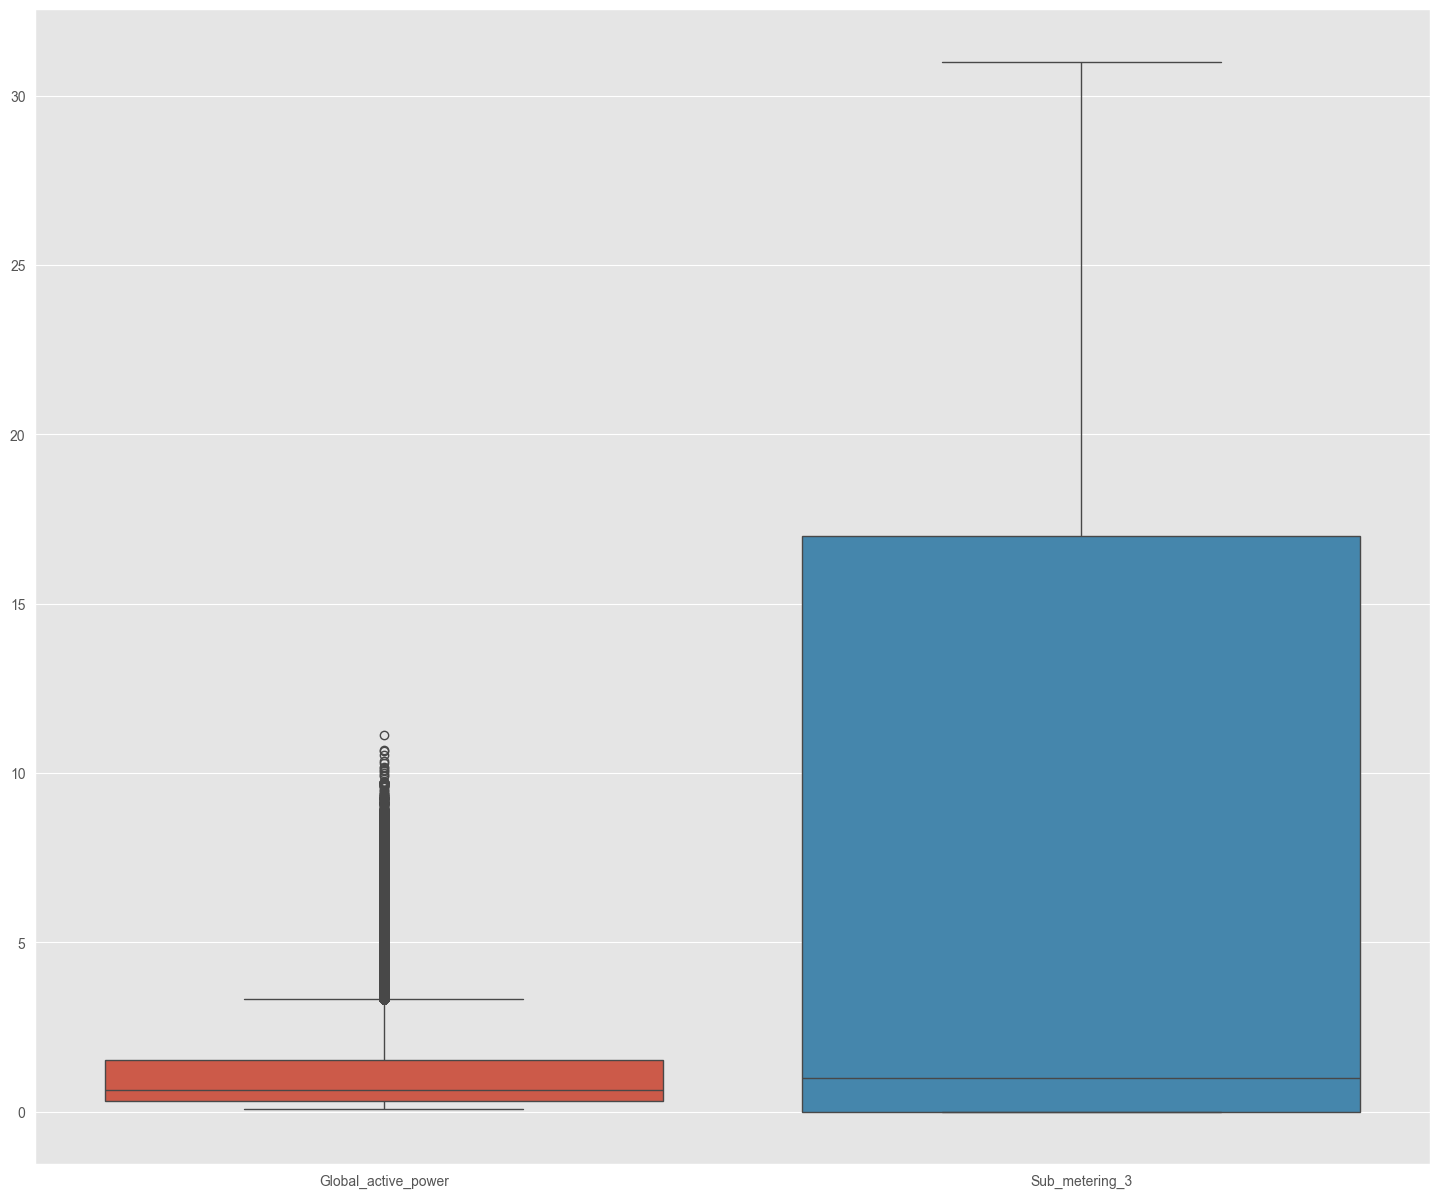

In [ ]:
# 데이터의 기술 통계량 확인
print(dataset.describe())

# 데이터의 분포 확인
import seaborn as sns
sns.boxplot(data=dataset)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 데이터를 2차원으로 재구성
num_instances, num_time_steps, num_features = X_Train.shape
X_Train_reshaped = X_Train.reshape(-1, num_features)

# 데이터 스케일링
scaler_X = MinMaxScaler()
X_Train_scaled = scaler_X.fit_transform(X_Train_reshaped)
X_Train_scaled = X_Train_scaled.reshape(num_instances, num_time_steps, num_features)

# Y_Train 스케일링 및 재구성.
scaler_Y = MinMaxScaler()
Y_Train_reshaped = Y_Train.reshape(-1, 1)
Y_Train_scaled = scaler_Y.fit_transform(Y_Train_reshaped)
# 형태 확인
print(X_Train_scaled.shape)
print(Y_Train_scaled.shape)

(1322, 60, 1)
(1322, 1)


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_Train_scaled,
    Y_Train_scaled,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]  # 조기 종료 콜백 추가
)

Epoch 1/100
17/17 [==============================] - 2s 37ms/step - loss: 0.0641 - mean_absolute_error: 0.2047 - val_loss: 0.0157 - val_mean_absolute_error: 0.0969
Epoch 2/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0282 - mean_absolute_error: 0.1276 - val_loss: 0.0141 - val_mean_absolute_error: 0.0901
Epoch 3/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0257 - mean_absolute_error: 0.1237 - val_loss: 0.0139 - val_mean_absolute_error: 0.0892
Epoch 4/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0245 - mean_absolute_error: 0.1196 - val_loss: 0.0125 - val_mean_absolute_error: 0.0854
Epoch 5/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0226 - mean_absolute_error: 0.1152 - val_loss: 0.0117 - val_mean_absolute_error: 0.0814
Epoch 6/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0217 - mean_absolute_error: 0.1132 - val_loss: 0.0117 - val_mean_absolute_error: 0.0813
Epoch 7/100
17/1

In [ ]:
print(X_Train.shape)

(1322, 60, 1)


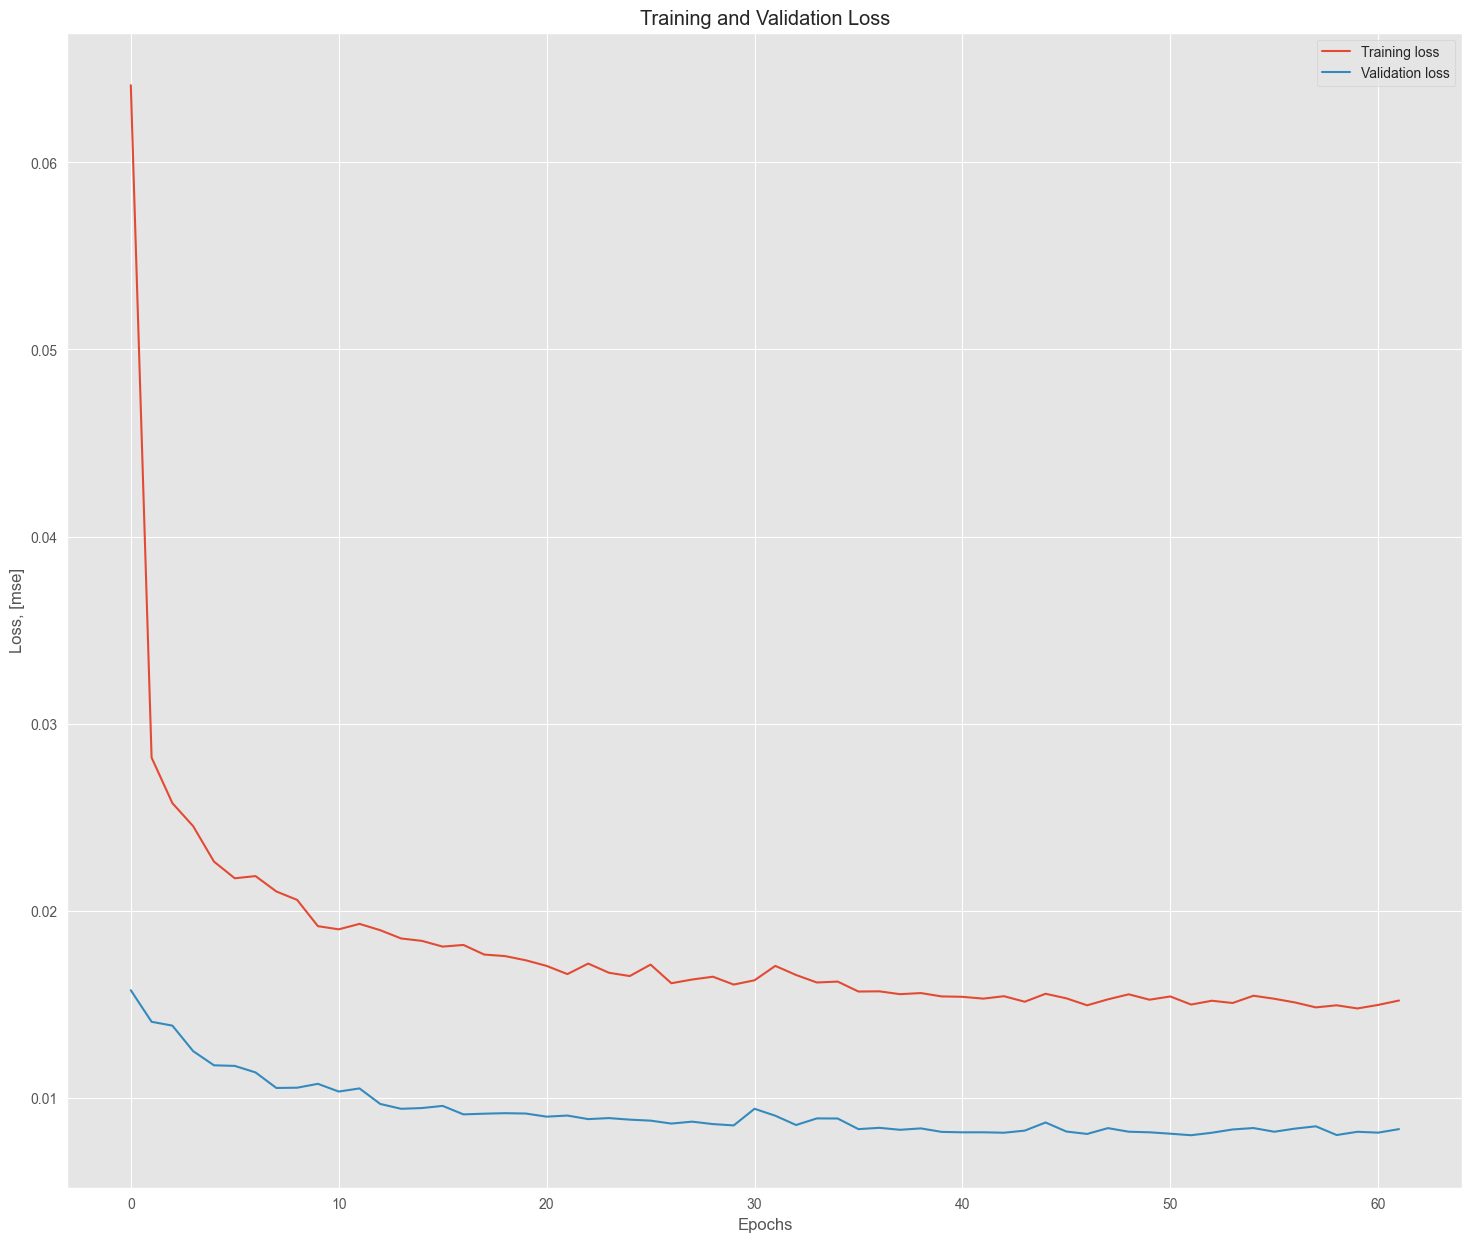

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
TestData.head(2)

,Global_active_power,Sub_metering_3
Date,,
2010-08-19,1.091615,NaN
2010-08-20,1.091615,NaN


In [ ]:
TestData.shape

(100, 2)

In [ ]:
NewDataSet.shape

(1442, 2)

In [ ]:
Df_Total = pd.concat((NewDataSet[["Global_active_power"]], TestData[["Global_active_power"]]), axis=0)

In [ ]:
Df_Total.shape

(1542, 1)

In [ ]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values
inputs.shape

(160, 1)

In [ ]:
# 입력 데이터 준비
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values

# 데이터 스케일링
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i])

# Numpy 배열로 변환
X_test = np.array(X_test)

# 모델에 입력할 수 있는 형태로 변환
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 모델을 사용하여 전력 사용량 예측
predicted_power = model.predict(X_test)

# 예측 결과를 2차원으로 변환 (예: 첫 번째 타임 스텝의 예측 값을 선택)
predicted_power = predicted_power[:, 0]

# 예측 결과를 원래 스케일로 변환
predicted_power = sc.inverse_transform(predicted_power.reshape(-1, 1))

4/4 [==============================] - 0s 4ms/step


In [ ]:
# 실제 값과 예측 값을 DataFrame으로 정리
True_Power = TestData["Global_active_power"].to_list()
Predicted_Power = [x[0] for x in predicted_power]
dates = TestData.index.to_list()

In [ ]:
Machine_Df = pd.DataFrame(data={
    "Date": dates,
    "TruePower": True_Power,
    "PredictedPower": Predicted_Power
})

In [ ]:
Machine_Df

,Date,TruePower,PredictedPower
0,2010-08-19,1.091615,1.128265
1,2010-08-20,1.091615,1.121404
2,2010-08-21,1.091615,1.115705
3,2010-08-22,1.041207,1.110984
4,2010-08-23,0.531707,1.101280
...,...,...,...
95,2010-11-22,1.417733,1.102481
96,2010-11-23,1.095511,1.145977
97,2010-11-24,1.247394,1.136041
98,2010-11-25,0.993864,1.143813


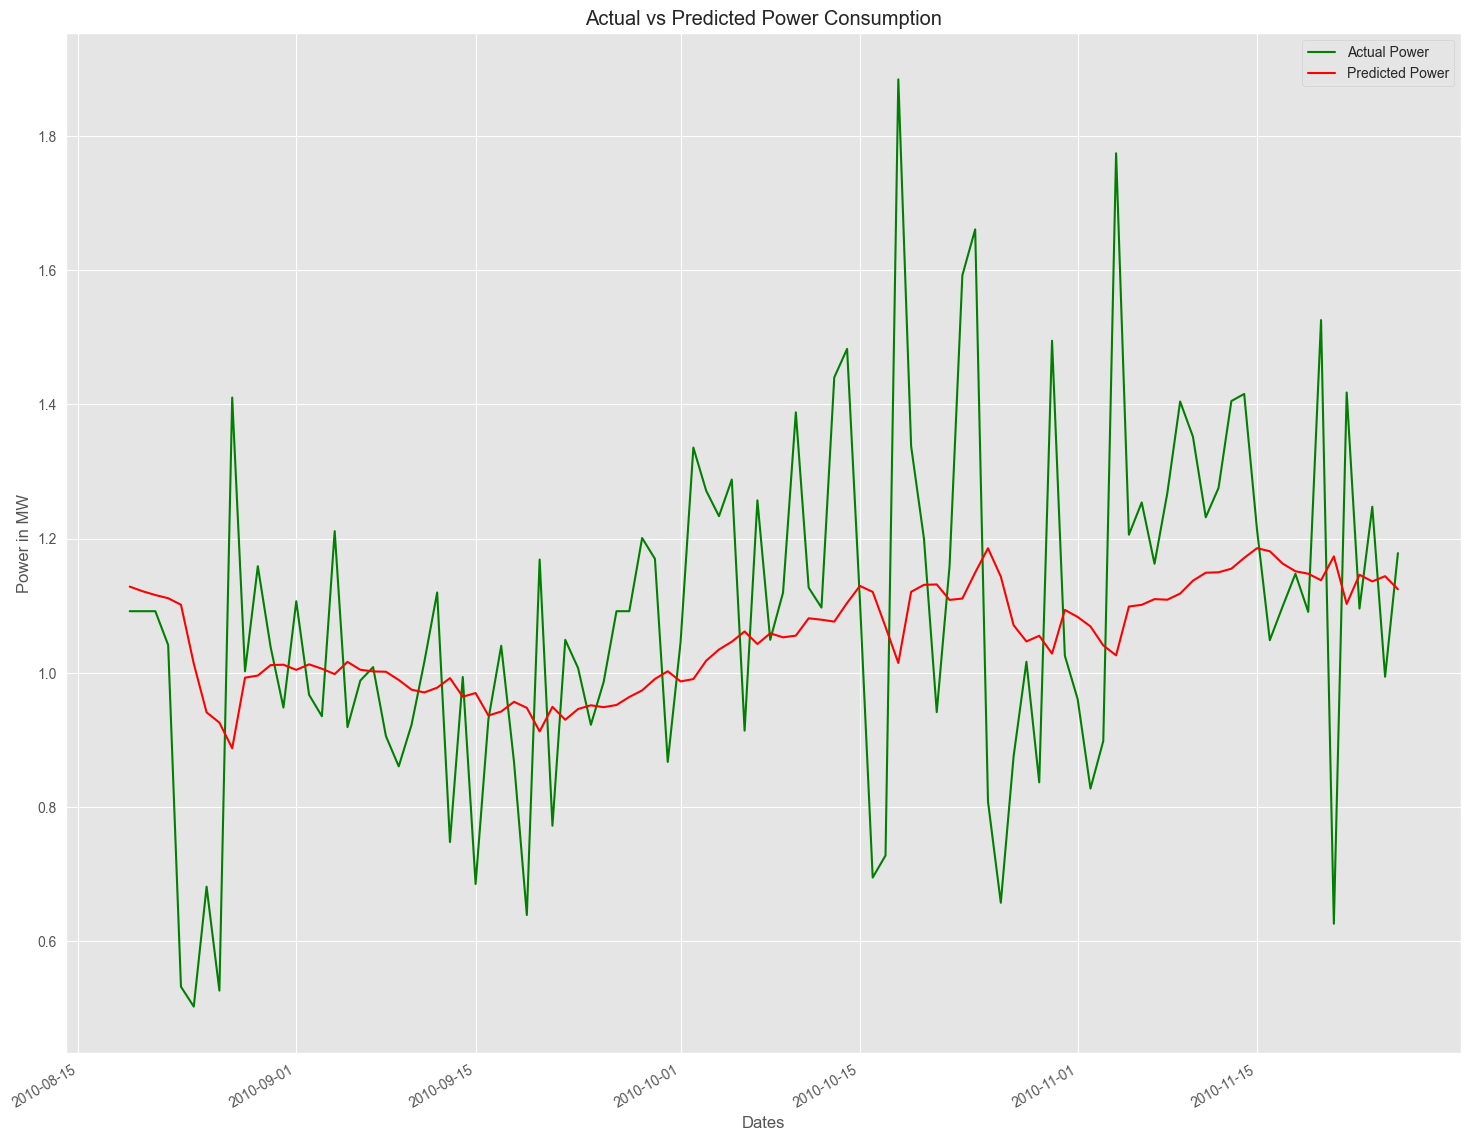

In [ ]:
# 그래프로 시각화
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.plot(dates, True_Power, color="green", label="Actual Power")
plt.plot(dates, Predicted_Power, color="red", label="Predicted Power")
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Actual vs Predicted Power Consumption")
plt.legend()

plt.show()